# Uncertainty Quantification in Graph Neural Networks
##### Project hand-in for 02456 Deep Learning @ Technical University of Denmark (Fall 2022)

In this notebook the key ideas behind Deep Evidential Learning will be presented and applied on a regression task using i) a simple 1D toy dataset for analyzing the model behaviour, ii) a synthetically created 3D graph dataset for being able to manipulate with OOD data as well as iii) the molecular 3D graph dataset QM7 for predicting molecular properties using an invariant message-passing network. This 3-step approach was chosen in order to break down the modeling task into simpler ones and for debugging purposes, both assisted in understanding how the models learn uncertainties.

**Authors:**
<br> Albert Kjøller Jacobsen      &nbsp;&emsp; (s194253@student.dtu.dk)
<br> Aron Djurhuus Jacobsen       &nbsp;&nbsp; (s194262@student.dtu.dk)
<br> Felix Borum Burmester        &nbsp;&emsp; (s194266@student.dtu.dk)
<br> Phillip Chavarria Højbjerg   &nbsp; (s184984@student.dtu.dk)

**Supervisor:** Mikkel Nørgaard Schmidt, DTU Compute


*NOTE: This notebook provides a quick run-down of the handed-in report with a special focus on providing the code associated to the reported results for reproducibility purposes. A detailed analysis of the obtained results is provided in the report.*

### Table of Contents <a class="anchor" id="0"></a>

- [1. Learning with uncertainty - why and how?](#1)
- [2. Towards self-conscious neural networks - Deep Evidential Learning](#2)
    - [2.1 - Modelling higher-order probabilities - the Normal-Inverse-Gamma distribution](#2.1)
    - [2.2 - Learning parameters of the NIG distribution](#2.2)
- [3. Deep Evidential Regression - evaluating the approach on a toy example](#3)
    - [3.1 - Training the 1D toy model](#3.1)
    - [3.2 - Evaluating the 1D toy model](#3.2)
- [4. Modeling graph-structured data - introducing Message-Passing Neural Networks](#4)
    - [4.1 - Defining the synthetic setup](#4.1)
    - [4.2 - Training the synthetic 3D model](#4.2)
    - [4.3 - Evaluating the synthetic 3D model](#4.3)
- [5. Applying uncertainty quantification to a down-stream task - Molecular Property prediction](#5)
    - [5.1 - The QM7 dataset](#5.1)
    - [5.2 - Training the model - predicting molecular energy](#5.2)
    - [5.3 - Evaluating the model](#5.3)
- [6. Discussion and Conclusion](#6)
- [7. Possible Extensions](#7)

### 0. Loading functionalities


In [49]:
import os, glob
from PIL import Image

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io


from omegaconf import OmegaConf

In [50]:
%matplotlib inline
#plt.style.use('seaborn-white')

### 1. Learning with uncertainty - why and how? <a class="anchor" id="1"></a>

<span style="color:red"> Introducing the (general) problem of interest - why do we need uncertainties?</span>

Machine Learning (ML) models - e.g. Deep Neural Networks - are validly deployed for solving several down-stream tasks due to their data-driven nature which often performs on par with other approaches. Though using such approaches often result in high performing models, these should be deployed with care when the modelled output/decision can have critical costs if modelled improperly - e.g. when classifying patient-related treatment, when estimating depth for visually acting robots or when predicting properties of molecules used within the field of medicine development. As such, capturing uncertainty of a Machine Learning model is crucial for several down-stream tasks and is a hot research topic within the field of Machine Learning.

But what is uncertainty? In fact, the word "uncertainty" does not reduce to a single meaning, but can instead be separated into different types of uncertainty, namely **aleatoric** and **epistemic** uncertainty. While aleatoric uncertainty captures uncertainty within the observed data that a Machine Learning model uses for training, epistemic uncertainty captures uncertainty regarding the model's prediction such that high uncertainty is associated to Out-of-Domain (OOD) data points where the model has limited evidence.

<center>
    <table><tr>
    <td> <img src="figures/aleatoric_simple.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="figures/epistemic_simple.png" alt="Drawing" style="width: 250px;"/> </td>
    </tr></table>
</center>

*Figures taken from [Amini et al. - Deep Evidential Regression.](https://arxiv.org/pdf/1910.02600.pdf)*


### 2. Towards self-conscious neural networks - Deep Evidential Learning <a class="anchor" id="2"></a>

What should be evident, is that aleatoric uncertainty can always be learned directly from data. More difficult is the task of modeling epistemic uncertainty, which one might think of as a kind of "self-conscious" or "self-aware" property of a model - it simply knows what it doesn't know and where it's predictive power is limited! One could argue that such a property should be a key component of all models that are to be deployed for solving a task. But how do we capture such "self-consciousness" when training deep neural networks?

While **Bayesian Neural Networks** validly provides the tools for obtaining representations of epistemic uncertainty by placing probabilistic priors on the parameters of a network, this model class suffers from several limitations - most prominent is the computational expense originating from e.g. the Monte Carlo sampling approach required as the analytical solution is intractable for deep neural networks.

Enter **Evidential Learning** - a method that approaches determination of epistemic uncertainty through an evidence acquisition process. Here, all acquired training points provides the basis for fitting a higher-order distribution, known as the **evidential distribution**, from which sampling results in lower-order likelihood functions. As such, this process directly places a higher-order prior on lower-order likelihood function rather than placing priors on network weights which is done when using Bayesian NNs.

In the paper [*Deep Evidential Regression* by Amini et al.](https://arxiv.org/pdf/1910.02600.pdf) they argue, that their method of using evidential learning on a regression task is new, as evidential learning has typically been applied for classification tasks <span style="color:red"> (as done by ... and ...) </span>. Furthermore, they argue that the task of defining a proper OOD exploited during training is unrealistic for most applications for most applications. Instead, they suggest an approach to evidential learning that solely leverages information from in-domain data points, yet still captures epistemic uncertainty on OOD data points.

So you might wonder were to start? In fact, training an evidential learning model using deep learning is quite straightforward - all we have to do is define the higher-order distribution of interest and setup a deep neural network that outputs the parameters of this distribution. How easy is that?

#### 2.1 - Modelling higher-order probabilities - the Normal-Inverse-Gamma distribution <a class="anchor" id="2.1"></a>

One way of approximating the higher-order, evidential distribution is by the use of the **Normal Inverse-Gamma (NIG) distribution**, for which the probability density function (PDF) is given by

$$
\begin{equation}
    p(\mu, \sigma^2 | \gamma, \nu, \alpha, \beta) =
        \frac{\beta^\alpha \sqrt{\nu}}
        {\Gamma(\alpha)\sqrt{2\pi\sigma^2}}
        \biggl ( \frac{1}{\sigma^2} \biggr )^{\alpha + 1}
        \exp \biggl (- \frac{2\beta + \nu ( \gamma - \mu )^2}{2\sigma^2}\biggr)
\end{equation}
$$

The NIG distribution assumes that the target, $(y_1, \dots, y_N)$ are i.i.d. and follow a Gaussian with unknown mean and variance, $\mu$ and $\sigma^2$, respectively. These are to be probabilistically estimated from the evidential priors. Assuming that observations are taken from a Gaussian (as Amini et al. argues) the evidential prior on the unknown mean, $\mu$, becomes a Gaussian prior, whereas the unknown variance, $\sigma^2$, gets assigned an Inverse-Gamma prior. This is summarized below:

$$
\begin{align*}
    (y_1, \dots, y_N) &\sim \mathcal{N}(\mu, \sigma^2) \\ \\
    \mu &\sim \mathcal{N}(\gamma, \sigma^2\nu^{-1}) \\
    \sigma^2 &\sim \Gamma^{-1}(\alpha, \beta)
\end{align*}
$$

For obtaining the expression given in the above equation, it is further assumed that the true posterior distribution can be estimated by a factorizable estimated posterior distribution, $q(\mu, \sigma^2) = p(\mu, \sigma^2 | y_1, \dots, y_N)$ such that $q(\mu, \sigma^2) = q(\mu) q(\sigma^2)$.

As such, this higher-order, evidential distribution can be sampled to obtain parameter-values $\mu_i$ and $\sigma_i^2$ that then define the lower-order likelihood distribution from which a variety of realizations can be sampled. The NIG distribution is implemented as a `class`-object below for visualizing the PDF when locking the parameters $\gamma, \nu, \alpha$ and $\beta$ to specific values.

In [51]:
from scipy.special import gamma as Gamma
from scipy.stats import expon, gengamma

# Inspiration from here: https://deebuls.github.io/devblog/probability/python/plotting/matplotlib/2020/05/19/probability-normalinversegamma.html
class NIG:
    def __init__(self, gamma, nu, alpha, beta):

        self.gamma, self.nu, self.alpha, self.beta = gamma, nu, alpha, beta
        assert alpha > 0 and beta >= 0 and nu >= 0

    def pdf(self, mu, sigma2):
        t1 = ((self.beta)**self.alpha) * ((self.nu)**0.5)
        t2 = Gamma(self.alpha) * (sigma2 * (2 * np.pi)**0.5)
        t3 = (1 / sigma2**2)**(self.alpha + 1)
        t4 = expon.pdf((2*self.beta + self.nu * (mu - self.gamma)**2)/(2*sigma2**2))
        return (t1/t2)*t3*t4

    def plot(self, zoom_out=5, steps=100, axs=None, colorbar=False, ylabel='on'):

        # max_sig_squared = gengamma.ppf(zoom, self.alpha, self.beta) * self.nu

        max_sig_squared = zoom_out
        mu_range = np.linspace(self.gamma - 1 * max_sig_squared, self.gamma + 1 * max_sig_squared, num=steps)
        sigma_range = np.linspace(0.01, max_sig_squared, num=steps)

        mu_grid, sigma_grid = np.meshgrid(mu_range, sigma_range)
        pdf_mesh = self.pdf(mu_grid, sigma_grid)

        if axs:
            X, Y, Z = np.sqrt(self.nu / self.beta) * (mu_grid - self.gamma), sigma_grid / self.beta, pdf_mesh
            cplot = axs.contourf(X, Y, Z, 10, cmap='Blues')

            axs.axis('equal')
            axs.set_title(rf"$\gamma$ = {self.gamma}, $\nu$ = {self.nu}, $\alpha$ = {self.alpha}, $\beta$ = {self.beta}", fontsize=20)
            axs.set_xlabel(r"$\sqrt{\frac{\nu}{\beta}}(\gamma - \mu)$", fontsize=20)
            if ylabel != 'off':
                axs.set_ylabel(r"$\sigma^2 / \beta $", fontsize=20)

            if colorbar == True:
                plt.colorbar(cplot)

Using the `NIG`-class we can plot how the distribution looks when fixing the parameter-values (inspiration taken from [here](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution)).

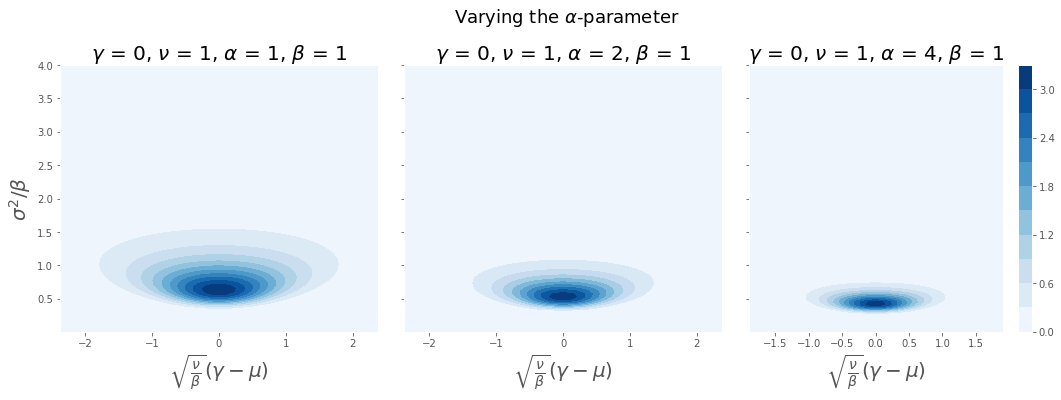

In [52]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
fig.suptitle(r'Varying the $\alpha$-parameter', fontsize=18)
fig.tight_layout(rect=[0, 0, 0.98, 0.95])

nig = NIG(gamma=0, nu=1, alpha=1,beta=1)
nig.plot(zoom_out=4.0, axs=axs[0])
nig = NIG(gamma=0, nu=1, alpha=2, beta=1)
nig.plot(zoom_out=4.0, axs=axs[1], ylabel='off')
nig = NIG(gamma=0, nu=1, alpha=4, beta=1)
nig.plot(zoom_out=4.0, axs=axs[2], colorbar=True, ylabel='off')

As can be seen on the above plot - where $\gamma=0, \nu=1$ and $\beta=1$ are set to (meaning that the axes corresponds to $-\mu$ and $\sigma^2$ respectively -, increasing the $\alpha$-parameter squeezes the area high probability mass towards a lower value of $\sigma^2$. This trend makes sense as the $\alpha$-parameter can be interpreted as virtual-observations (evidence) related to the $\sigma^2$-parameter.

##### What are the learned parameters useful for?
The parameters of the NIG distribution can be directly related to the prediction of the model as well as its aleatoric and epistemic uncertainties. These are defined as follows (in order 'prediction', 'aleatoric', 'epistemic'):

$$
    \mathbb{E}[\mu] = \gamma, \qquad\qquad \mathbb{E}[\sigma^2] = \frac{\beta}{\alpha - 1}, \qquad\qquad \text{Var}[\mu] = \frac{\beta}{\nu(\alpha - 1)}
$$

So, the setup proposed by Amini et al. provides a framework for decoupling the total uncertainty of the model into its aleatoric and epistemic subparts!

#### 2.2 - Learning parameters of the NIG distribution <a class="anchor" id="2.2"></a>

Similarly to other optimization task for deep learning, learning the parameters of the evidential distribution can be done through **Maximum Likelihood Estimation (MLE)**, thereby minimizing the **negative log-likelihood (NLL)**. Applying the NLL approach directly on the NIG distribution, the loss term becomes

\begin{equation}
    \mathcal{L}_i^{\mathrm{NLL}}(\boldsymbol{w})=\frac{1}{2} \log \left(\frac{\pi}{v}\right)-\alpha \log (\Omega)+\left(\alpha+\frac{1}{2}\right) \log \left(\left(y_i-\gamma\right)^2 v+\Omega\right)+\log \left(\frac{\Gamma(\alpha)}{\Gamma\left(\alpha+\frac{1}{2}\right)}\right)
\end{equation}

where $\Omega=2 \beta(1+v)$. The effect of this loss-term is that the neural network learns to fit observations by maximizing model evidence.

For emphasizing high epistemic uncertainty for OOD data points, an additional loss term penalizing model evidence by the absolute error of the model's prediction is included. This loss termand acts as a regularizer and is given by
\begin{equation}
    \mathcal{L}_i^{\mathrm{R}}(\boldsymbol{w})=\left|y_i-\gamma\right| \cdot(2 v+\alpha)
\end{equation}

The combined loss includes a scaling parameter, $\lambda$ on the regularization term and thus becomes
\begin{equation}
    \mathcal{L}_i(\boldsymbol{w})=\mathcal{L}_i^{\mathrm{NLL}}(\boldsymbol{w})+\lambda \mathcal{L}_i^{\mathrm{R}}(\boldsymbol{w})
\end{equation}

As Armini et al. argues, setting $\lambda=0$ results in an over-confident model for OOD data while a value of $\lambda$ too high will inflate model uncertainty. For respecting the natural structure of the NIG distribution, the learned parameters are restricted by applying various activation functions on the outputs of the output layer. As such $\gamma$ gets a linear activation as it equals the model prediction, $\nu$ and $\beta$ must be positive runs through a softplus activation, whereas $\alpha$ must be above 1 for which reason the softplus activation and addition of 1 is applied on the output level.

The total loss is implemented as a class, `NIGLoss`, containing all subparts of the total loss-function.

In [53]:

import torch
from torch.nn import GaussianNLLLoss


class NIGLoss:
    def __init__(self, lambd_) -> None:
        self.lambd_ = lambd_
        self.scalar = None

    def __call__(self, evidential_params_, y, kappa=0, training=True):
        """
        Forward pass through the NIGLoss function.

        Parameters
        ----------
        evidential_params_: parameters of the evidential distribution (shape: batch_size x 4)
        y: target attribute of the regression task (shape: batch_size x 1)
        kappa: trade-off parameter between RMSE and NIG loss

        Returns
        -------
        A tuple of the total loss as well as a dictionary of "extra" losses / subparts of the total loss.
        ('Loss', total_loss), {'NLL': nll_loss, 'REG': reg_loss, 'RMSE': rmse_loss}

        """
        # Separate the evidential parameters
        self.gamma, self.nu, self.alpha, self.beta = evidential_params_[:, 0].reshape(-1, 1), \
                                                     evidential_params_[:, 1].reshape(-1, 1), \
                                                     evidential_params_[:, 2].reshape(-1, 1), \
                                                     evidential_params_[:, 3].reshape(-1, 1)

        # Get losses
        y = y.reshape(-1, 1)

        # if training on scaled data
        if self.scalar is not None:

            # if in eval, then models outputs descaled data
            if training: # then scale target variable

                # de-scale y for NLL loss
                nll_loss = self.NIG_NLL(torch.from_numpy(self.scalar.transform(y)))
                reg_loss = self.NIG_REGULARIZER(torch.from_numpy(self.scalar.transform(y)))
                # de-scale gamma for RMSE
                rmse_loss = torch.sqrt(torch.mean((torch.from_numpy(self.scalar.inverse_transform(self.gamma.detach())) - y) ** 2))

                # Compute total loss
                total_loss = nll_loss + (self.lambd_ * reg_loss)
                total_loss = (1 - kappa) * total_loss.mean() + kappa * rmse_loss

            else: # not training and model output is descaled
                # rmse is as normal (model output has been converted)
                rmse_loss = torch.sqrt(torch.mean((self.gamma - y) ** 2))
                # NLL has to be scaled on both terms
                y = torch.from_numpy(self.scalar.transform(y))
                nll_loss = self.NIG_NLL(y)
                reg_loss = self.NIG_REGULARIZER(y)

        else:
            # Compute loss like normal
            nll_loss = self.NIG_NLL(y)
            reg_loss = self.NIG_REGULARIZER(y)
            rmse_loss = torch.sqrt(torch.mean((self.gamma - y) ** 2))

        # Compute total loss
        total_loss = nll_loss + (self.lambd_ * reg_loss)
        total_loss = (1 - kappa) * total_loss.mean() + kappa * rmse_loss
        return ('Loss', total_loss), {'NLL': nll_loss.mean(), 'REG': reg_loss.mean(), 'RMSE': rmse_loss}

    def NIG_NLL(self, y):
        """
        Computes negative log-likelihood of the NIG distribution for a regression target, y. Maximizes model fit.
        Implementation follows Equation 8 in this paper (https://arxiv.org/pdf/1910.02600.pdf)

        """
        omega = 2 * self.beta * (1 + self.nu)
        nll = 0.5 * torch.log(torch.pi / (self.nu)) \
              - self.alpha * torch.log(omega) \
              + (self.alpha + 0.5) * torch.log((y - self.gamma) ** 2 * self.nu + omega) \
              + torch.lgamma(self.alpha) - torch.lgamma(self.alpha + 0.5)
        return nll

    def NIG_REGULARIZER(self, y):
        """
        Computes regularizing loss on the NIG distribution for a regression target, y. Minimizes evidence on errors by
        scaling the error with the total evidence of the infered posterior.
        Implementation follows Equation 9 in this paper (https://arxiv.org/pdf/1910.02600.pdf)
        """
        return abs(y - self.gamma) * (2 * self.nu + self.alpha)


class RMSELoss:
    def __init__(self, ) -> None:
        pass

    def __call__(self, mu, y):
        self.mu = mu.reshape(-1,1)
        self.y = y.reshape(-1,1)

        # Get losses
        rmse_loss = torch.sqrt(torch.mean((self.mu - self.y)**2))
        # Compute total loss
        return ('RMSE', rmse_loss), {}

### 3. Deep Evidential Regression - evaluating the approach on a toy example <a class="anchor" id="3"></a>

Thinking of aleatoric and epistemic uncertainties for multi-dimensional data is abstract and these concepts are often hard to grasp with as defining In- and Out-of-Domain data can be a hard task. For this reason, the evidential learning strategy using the defined NIG loss is applied to a simple 1D example where the various uncertainty types can be interpreted visually.

The 1D toy regression task consists in approximating a 3rd order polynomial where observations of the target variable are affected by a noise source. This noise is modelled as Gaussian noise with a variance of 3 and the problem can be described as

$$
    y = x^3 + \epsilon, \qquad \epsilon \sim \mathcal{N}(0, 3)
$$

The regression task at hand then consists of learning to approximate the 3rd order polynomial using a restricted training set, i.e. $x \in [-4, 4]$. During validation the model is further evaluated on OOD data, i.e. $x \in [-6, 6]$. As the purpose is only to visually inspect the evidential learning approach, no test dataset is defined.

Using the auxiliary function `load_data` (found in content/modules/utils.py) this simple regression problem is loaded as a dictionary containing a train, validation and test set.

In [54]:
from content.modules.utils import load_data

# Specify arguments for the load_data function
DATA_DIR = f'content/data'
DATASET = 'TOY1D'
BATCH_SIZE = 128
N_POINTS = 1024
DEVICE = 'cpu'
SEED = 0

# Create configuration dictionary
args = OmegaConf.create({'data_dir': DATA_DIR, 'dataset': DATASET, 'N_points': N_POINTS, 'toy_noise_level': 3,
                         'batch_size': BATCH_SIZE, 'device': DEVICE, 'seed': SEED})

# Create dataloaders
dataloaders = load_data(args)
print(f"Loaded toy dataset!\nDataset types available: {[type_ for type_ in dataloaders.keys() if dataloaders[type_] != None]}")

Loaded toy dataset!
Dataset types available: ['train', 'val', 'test', 'visualization']


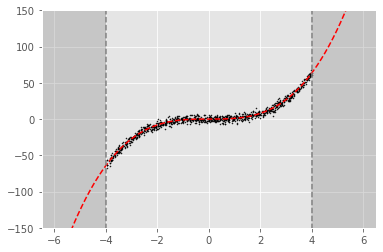

In [55]:
dataloaders['visualization'].visualize_dataset()

In [56]:
dataloaders = {key: dataloaders[key] for key in ['train', 'val', 'test']}

#### 3.1 - Training the 1D toy model <a class="anchor" id="3.1"></a>

Following the descriptions of the evidential learning problem previously mentioned, the `EvidentialToyModel1D` is defined below. The model takes a one-dimensional input and forward it through a neural network that outputs the four parameters for the evidential distribution with their respective output activations. Though pilot runs were carried out using the architecture from Amini et al. (3 hidden layers with 100 neurons each) we use a simplified architecture of only one hidden layer as the regression task is rather simple. Design choices include initializing the weights using the Kaiming Normal method due to using the ReLU activation function as well as adding an epsilon to some of the outputted parameters (for numerical reasons when computing the loss).

In [57]:
class EvidentialToyModel1D(torch.nn.Module):
    """
    Toy model for investigating evidential learning for approximating a simple 3rd order polynomial in a 1D setting.
    """

    def __init__(self, hidden_dim=100, eps=1e-7):
        super().__init__()
        self.model_type = 'evidential'
        self.scalar = None

        # Regression network for 1D toy task
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 4), # (gamma, nu, alpha, beta)
        )
        # Initialize weights
        self.net.apply(self.init_weights)
        self.eps = eps

        # Speficy activation functions
        self.softplus = torch.nn.Softplus()

    def init_weights(self, layer): # Found here: https://www.askpython.com/python-modules/initialize-model-weights-pytorch
        if type(layer) == torch.nn.Linear:
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = x.data
        # Get parameters of NIG distribution (4-dimensional output)
        evidential_params_ = self.net(x) # (gamma, v, alpha, beta)
        # Apply activations as specified after Equation 10 in the paper
        gamma, nu, alpha, beta = torch.tensor_split(evidential_params_, 4, axis=1)
        out = torch.concat([gamma,
                            self.softplus(nu) + self.eps,
                            self.softplus(alpha).to(torch.float64).add(1) + self.eps,
                            self.softplus(beta) + self.eps],
                           axis=1)
        return out

We use the Adam optimizer and hyperparameters specified in the cell below.

In [58]:
from run import determine_run_version

args = OmegaConf.create({})

# TRAINING-RELATED PARAMETERS
HIDDEN_DIM = 100
args.lr = LR = 5e-3
args.loss_function = LOSS_FUNCTION = 'NIGLoss'
args.epochs = EPOCHS = 625
args.kappa = KAPPA = 0.0
args.kappa_decay = KAPPA_DECAY = 1.0
args.seed = SEED = 0
args.device = DEVICE = 'cpu'

# EXPERIMENT-RELATED PARAMETERS
VAL_EVERY_STEP = 5
EXPERIMENT_NAME = 'TOY1D'
args.tensorboard_logdir = TENSORBOARD_LOGDIR = 'logs'
args.save_path = SAVE_PATH = 'models'

# DATASET
args.batch_size = BATCH_SIZE
args.dataset = DATASET

Now, training the model is straight-forward - just look below! The training loop is defined as a function which can be found in the file content/train.py and images revealing how aleatoric and epistemic uncertainties as well as values of the evidential parameters are distributed over the validation range, $x \in [-6, 6]$, are saved and used for visualizations later on.

In the following cells we run through the training loop three times for examining the importance of the regularization parameter, $\lambda$ - we examine for the values $[0.001, 0.01, 0.1]$.

In [59]:
from content.train import train

best_epochs = {}

args.NIG_lambda = NIG_LAMBDA = 0.001
EXPERIMENT_VERSION = f'lambda{NIG_LAMBDA}'
args.experiment_name = f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}"

# TRAINING-RELATED CLASSES
model = EvidentialToyModel1D(hidden_dim=HIDDEN_DIM)
model.to(torch.device(args.device))

loss_function = NIGLoss(lambd_=NIG_LAMBDA)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Run training loop
os.makedirs(f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")
model, best_epoch = train(dataloaders, model, optimizer, loss_function,
                          epochs=EPOCHS, kappa=KAPPA, kappa_decay=KAPPA_DECAY,
                          val_every_step=VAL_EVERY_STEP, experiment_name=f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}",
                          tensorboard_logdir=TENSORBOARD_LOGDIR, tensorboard_filename=determine_run_version(args),
                          save_path=f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")
best_epochs[NIG_LAMBDA] = best_epoch

Train Loss: 2.545 	 | 	 Train RMSE: 3.035 	 | 	 Val Loss: 2.539 	| 	 Val RMSE: 3.025 | Progress: 100%|██████████| 625/625 [01:22<00:00,  7.56it/s] 


EPOCH 620 --> BEST CHECKPOINT SAVED!	 Validation Loss: 2.5390666339666503


In [60]:
args.NIG_lambda = NIG_LAMBDA = 0.01
EXPERIMENT_VERSION = f'lambda{NIG_LAMBDA}'
args.experiment_name = f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}"

# TRAINING-RELATED CLASSES
model = EvidentialToyModel1D(hidden_dim=HIDDEN_DIM)
model.to(torch.device(args.device))

loss_function = NIGLoss(lambd_=NIG_LAMBDA)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Run training loop
os.makedirs(f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")
model, best_epoch = train(dataloaders, model, optimizer, loss_function,
                          epochs=EPOCHS, kappa=KAPPA, kappa_decay=KAPPA_DECAY,
                          val_every_step=VAL_EVERY_STEP, experiment_name=f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}",
                          tensorboard_logdir=TENSORBOARD_LOGDIR, tensorboard_filename=determine_run_version(args),
                          save_path=f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")
best_epochs[NIG_LAMBDA] = best_epoch


Train Loss: 2.608 	 | 	 Train RMSE: 3.052 	 | 	 Val Loss: 2.606 	| 	 Val RMSE: 3.044 | Progress: 100%|██████████| 625/625 [01:20<00:00,  7.80it/s] 


EPOCH 620 --> BEST CHECKPOINT SAVED!	 Validation Loss: 2.6064242052426962


In [61]:
args.NIG_lambda = NIG_LAMBDA = 0.1
EXPERIMENT_VERSION = f'lambda{NIG_LAMBDA}'
args.experiment_name = f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}"

# TRAINING-RELATED CLASSES
model = EvidentialToyModel1D(hidden_dim=HIDDEN_DIM)
model.to(torch.device(args.device))

loss_function = NIGLoss(lambd_=NIG_LAMBDA)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Run training loop
os.makedirs(f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")
model, best_epoch = train(dataloaders, model, optimizer, loss_function,
                          epochs=EPOCHS, kappa=KAPPA, kappa_decay=KAPPA_DECAY,
                          val_every_step=VAL_EVERY_STEP, experiment_name=f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}",
                          tensorboard_logdir=TENSORBOARD_LOGDIR, tensorboard_filename=determine_run_version(args),
                          save_path=f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")
best_epochs[NIG_LAMBDA] = best_epoch


Train Loss: 2.844 	 | 	 Train RMSE: 3.057 	 | 	 Val Loss: 2.837 	| 	 Val RMSE: 3.048 | Progress: 100%|██████████| 625/625 [01:16<00:00,  8.19it/s] 


EPOCH 620 --> BEST CHECKPOINT SAVED!	 Validation Loss: 2.8371617159239753


The learning curves of these three runs are visualized below by extracting the information stored in the associated Tensorboard logs.

In [62]:
from content.modules.utils import _load_tb_run

def extract_tb_results(args):
    # Extract tensorboard scalars
    data = _load_tb_run(rf"{args.tensorboard_logdir}/{determine_run_version(args)}")
    res = {key: pd.DataFrame(tb_vals, index=['epochs', key]).T for key, tb_vals in data.items()}

    # Separate training losses
    df_train = res['TRAIN/Loss'].drop('TRAIN/Loss', axis=1)
    for key in res.keys():
        if 'TRAIN' in key:
            df_train = df_train.merge(res[key], on='epochs').rename(columns={key: key.split('/')[-1]})

    # Separate validation losses
    df_val = res['VALIDATION/Loss'].drop('VALIDATION/Loss', axis=1)
    for key in res.keys():
        if 'VALIDATION' in key:
            df_val = df_val.merge(res[key], on='epochs').rename(columns={key: key.split('/')[-1]})

    return df_train, df_val

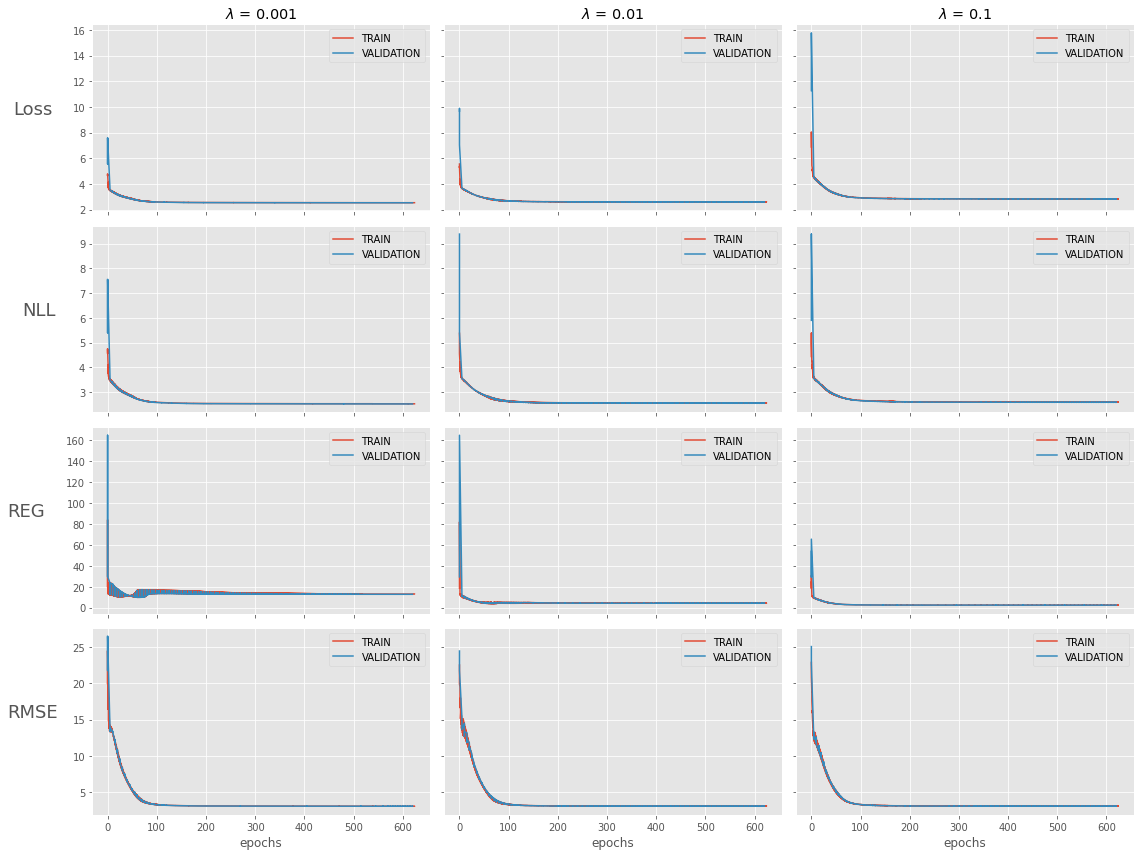

In [63]:
lambdas = [0.001, 0.01, 0.1]
losses = ['Loss', 'NLL', 'REG', 'RMSE']

fig, axs = plt.subplots(len(losses), len(lambdas), figsize=(16, 12), sharex=True, sharey='row')
for j, lambda_ in enumerate(lambdas):

    args.NIG_lambda = NIG_LAMBDA = lambda_
    EXPERIMENT_VERSION = f'lambda{NIG_LAMBDA}'
    args.experiment_name = f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}"

    # Get tb results
    df_train, df_val = extract_tb_results(args)

    for i, loss_name in enumerate(losses):
        df_train.plot(x='epochs', y=loss_name, ax=axs[i, j], label='TRAIN')
        df_val.plot(x='epochs', y=loss_name, ax=axs[i, j], label='VALIDATION')
        if i == 0:
            axs[i, j].set_title(f'$\lambda$ = {args.NIG_lambda}')
        if j == 0:
            axs[i, j].set_ylabel(loss_name, rotation=0, labelpad=40, fontsize=18)

plt.tight_layout()
plt.show()

Additionally, the best epochs and the associated uncertainties as well as the values of the evidential parameters are visualized in the current cells for comparing the values of lambda.

In [64]:
def visualize_best_epoch(experiment_name, best_epoch, model_type: str, title=None):
    if model_type == 'EVIDENTIAL':
        subfolders = ['ALEATORIC', 'EPISTEMIC', 'PARAMS']
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    elif model_type == 'BASELINE':
        subfolders = ['BASELINE', 'PARAMS']
        experiment_name += "/baseline"
        fig, axs = plt.subplots(1, 2, figsize=(16, 16))

    images = [Image.open(f"results/{experiment_name}/{uncertainty_type}/0{best_epoch}.png") for uncertainty_type in subfolders]

    for i, ax in enumerate(axs):
        ax.imshow(images[i])
        ax.axis('off')

    if title != None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()

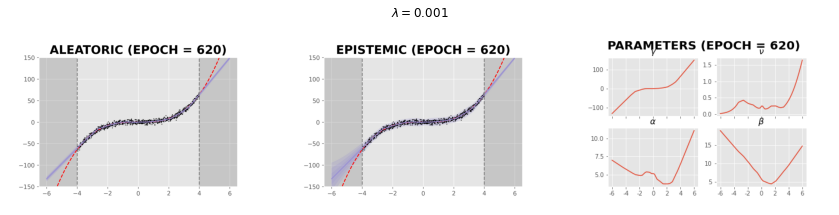

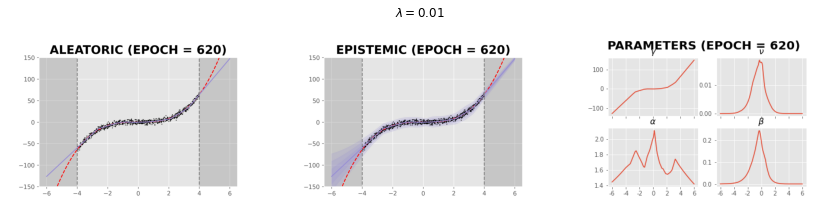

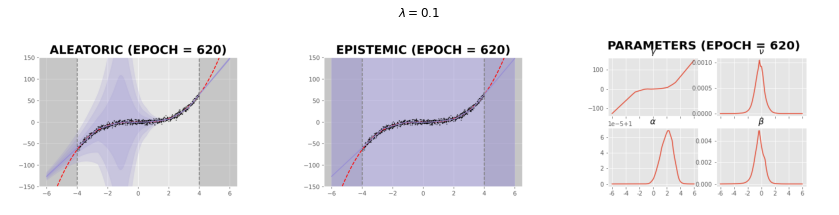

In [65]:
#best_epochs = {0.001: 75, 0.01: x, 0.1: xx}

for lambda_, best_epoch in best_epochs.items():
    EXPERIMENT_VERSION = f"lambda{lambda_}"
    visualize_best_epoch(f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}", best_epoch=best_epoch, model_type='EVIDENTIAL', title=f'$\lambda = {lambda_}$')

What we see in this analysis is, that the model is very sensitive to the lambda-value which has been further tested by trying out different random seeds. We do however see, that choosing the correct value can give reasonable uncertainty estimates on the 1D example. We expect this to be harder when extending the situation to a 3D scenario of molecular property prediction, as there is no direct way of interpreting model uncertainty visually.

*Note:* Previous pilot runs revealed that the model overfitted to this setting however, the current learning curves does not really imply this. Unfortunately, the parameters of those runs were not stored, however, the associated images are shown below. These are a bit more meaningful than what was seen in the final run of this notebook, providing more evidence, that the evidential learning approach suggested by Amini et al. is very sensitive to the initialization.

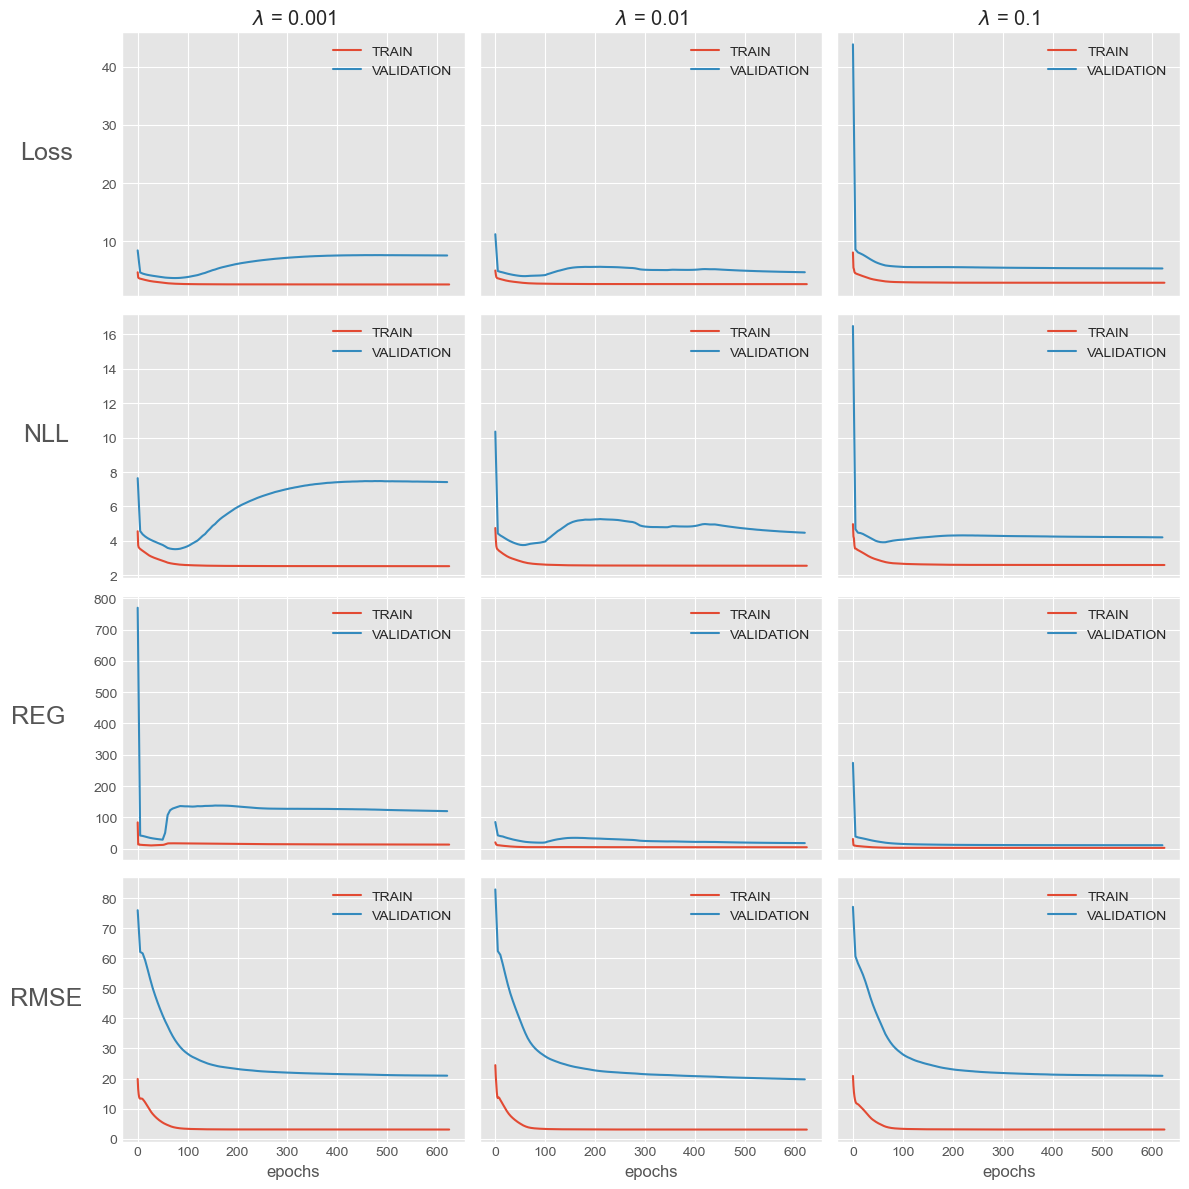

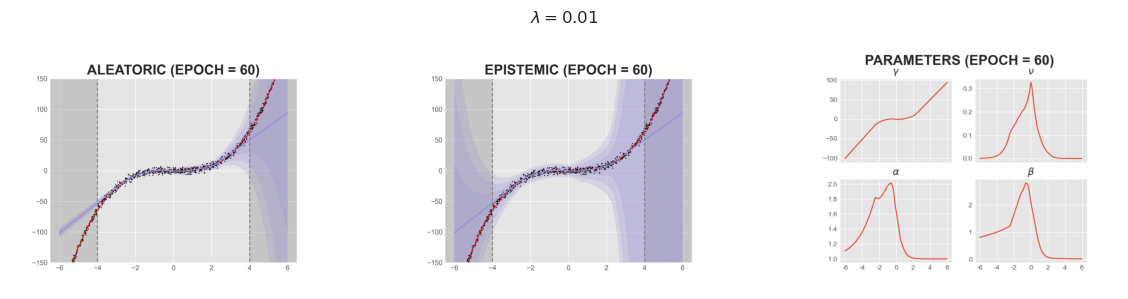

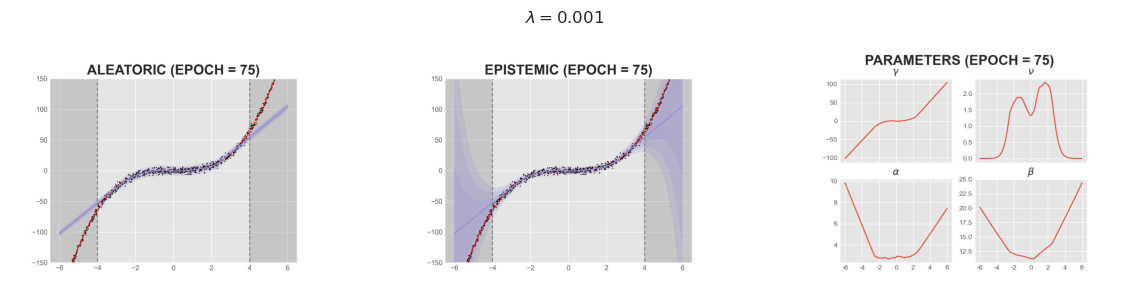

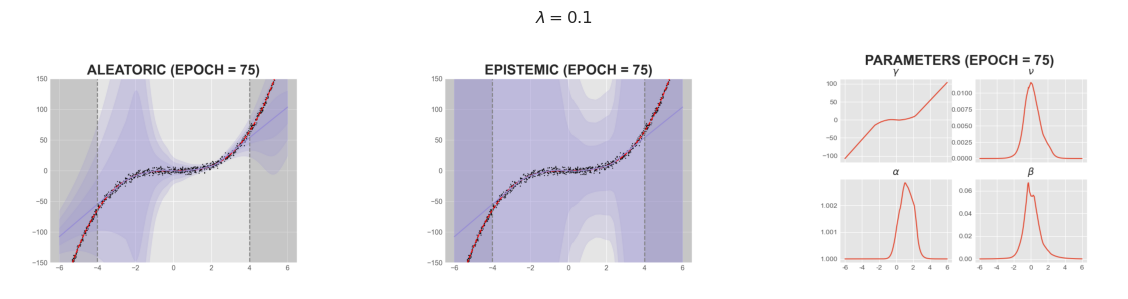

##### Optional: Plot and show GIF of the learning problem

As plots are saved after every `VAL_EVERY_STEP` epochs, we can easily visualize the learning process as a GIF. Run the code below for seeing the content of the following Markdown cell. Run the following cell and check the results folder - it should containt three GIF of the above figures.

In [ ]:
from content.evaluate import make_gif

# Create GIFs
make_gif(f"results/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}/ALEATORIC",   'aleatoric', duration=100)
make_gif(f"results/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}/EPISTEMIC",   'epistemic', duration=100)
make_gif(f"results/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}/PARAMS",      'parameters', duration=100)

#### 3.2 - Training the baseline - Gaussian MLE

We further wish to compare the trained model to a Gaussian MLE. The network outputs the two parameters for the MLE and we define a GaussianNLL as the loss function.

In [67]:
class BaselineToyModel1D(torch.nn.Module):
    """
    Toy baseline model for investigating gaussian MLE learning for approximating a simple 3rd order polynomial in a 1D setting.
    """

    def __init__(self, hidden_dim=100):
        super().__init__()
        self.model_type = 'baseline'
        self.scalar = None

        # Regression network for 1D toy task
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 2), # (mu, sigma)
        )
        # Initialize weights
        self.net.apply(self.init_weights)

        # Speficy activation functions
        self.softplus = torch.nn.Softplus()

    def init_weights(self,layer):  # Found here: https://www.askpython.com/python-modules/initialize-model-weights-pytorch
        if type(layer) == torch.nn.Linear:
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = x.data
        # Get parameters of Gaussian distribution (2-dimensional output)
        gaussian_params_ = self.net(x)  # (gamma, v, alpha, beta)
        mu, sigma = torch.tensor_split(gaussian_params_, 2, axis=1)
        out = torch.concat([mu,
                            self.softplus(sigma)],
                           axis=1)
        return out


In [75]:
class GAUSSIANNLLLoss:
    def __init__(self, ) -> None:
        # loss function
        self.loss_func = GaussianNLLLoss(reduction='mean')
        self.scalar = None
    def __call__(self, theta, y, kappa=0, training=True):
        mu = theta[:,0].reshape(-1,1)
        var = theta[:, 1].reshape(-1, 1)
        y = y.reshape(-1, 1)

        # if training on scaled data
        if self.scalar is not None:
            # if in eval, then models outputs descaled data
            if training: # then scale target variable
                # de-scale target for NLL loss
                nll_loss = self.loss_func(target=torch.from_numpy(self.scalar.transform(y)), input=mu, var=var)
                # de-scale prediction for RMSE
                rmse_loss = torch.sqrt(torch.mean((torch.from_numpy(self.scalar.inverse_transform(mu.detach())) - y) ** 2))

            else: # not training and model output is descaled
                # rmse is as normal (model output has been converted)
                rmse_loss = torch.sqrt(torch.mean((mu - y) ** 2))
                # NLL has to be scaled on both terms
                y = torch.from_numpy(self.scalar.transform(y))
                # scaling for NLL loss
                mu = torch.from_numpy(self.scalar.transform(mu))
                var = var/self.scalar.var_
                nll_loss = self.loss_func(target=y, input=mu, var=var)

        else:
            # Compute loss like normal
            nll_loss = self.loss_func(target=y, input=mu, var=var)
            rmse_loss = torch.sqrt(torch.mean((mu - y)**2))


        # kappa automatically decays if defined
        #   - loss is Gaussian NLL if kappa is not defined
        loss = (1 - kappa) * nll_loss + kappa * rmse_loss

        return ('Loss', loss), {'GAUSSIANNLL': nll_loss, 'RMSE': rmse_loss}

Similarly to the evidential learning approach, we specify the input arguments and run the model training loop.

In [76]:
# TRAINING-RELATED PARAMETERS
HIDDEN_DIM = 100
args.lr = LR = 5e-3
args.loss_function = LOSS_FUNCTION = 'GAUSSIANNLL'

# EXPERIMENT-RELATED PARAMETERS
VAL_EVERY_STEP = 5
EXPERIMENT_NAME = 'BASELINE1D'
EXPERIMENT_VERSION = 'v1'
args.epochs = 625
args.tensorboard_logdir = TENSORBOARD_LOGDIR = 'logs'
args.kappa = 0
args.kappa_decay = 1
args.save_path = SAVE_PATH = 'models'

args.experiment_name = f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}"

In [78]:
# TRAINING-RELATED PARAMETERS

EXPERIMENT_VERSION = 'v1'

model = BaselineToyModel1D(hidden_dim=HIDDEN_DIM)
model.to(torch.device(args.device))

loss_function = GAUSSIANNLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Run training loop
os.makedirs(f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")
model, best_epoch = train(dataloaders, model, optimizer, loss_function, epochs=EPOCHS,
                          val_every_step=VAL_EVERY_STEP, experiment_name=f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}",
                          tensorboard_logdir=TENSORBOARD_LOGDIR, tensorboard_filename=determine_run_version(args),
                          save_path=f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")

Train Loss: 1.829 	 | 	 Train RMSE: 4.106 	 | 	 Val Loss: 1.831 	| 	 Val RMSE: 4.121 | Progress: 100%|██████████| 625/625 [00:44<00:00, 13.99it/s]       


EPOCH 620 --> BEST CHECKPOINT SAVED!	 Validation Loss: 1.8309335261583328


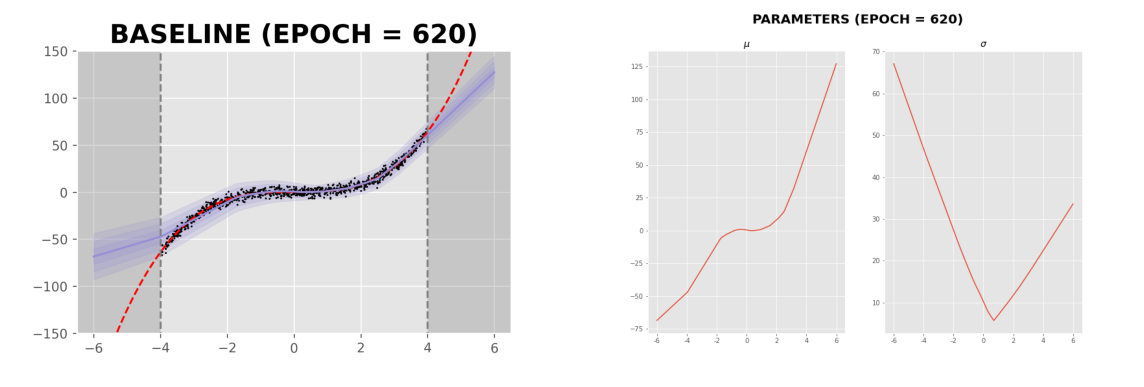

In [79]:
visualize_best_epoch(args.experiment_name, model_type='BASELINE', best_epoch=best_epoch)

#### 3.3 - Evaluating model performances on the 1D toy problem <a class="anchor" id="3.2"></a>

Running in evaluation mode will produce plots and figures that are suitable for comparing model performance on the 1D problem. This is simulated with the arguments provided in the following cells. The resulting figures will be outputted to a directory named `results` in your root-directory.

In [80]:
from omegaconf import OmegaConf
from content.modules.utils import load_data

DATA_DIR = 'content/data'
BATCH_SIZE = 128
SAVE_PATH = 'models'
SEED = 0

In [81]:
args = OmegaConf.create({})

# TRAINING-RELATED PARAMETERS
args.mode = 'evaluation'
args.data_dir = DATA_DIR
args.batch_size = BATCH_SIZE
args.dataset = ['TOY1D', 'TOY1D']
args.N_points = 1024
args.toy_noise_level = 3
args.id_ood = ['ID', 'ID']

args.model = ['TOY1D', 'BASE1D']
args.experiment_name = ['TOY1D-lambda0.001', 'BASELINE1D-v1']
args.save_path = SAVE_PATH
args.device = 'cpu'
args.seed = SEED

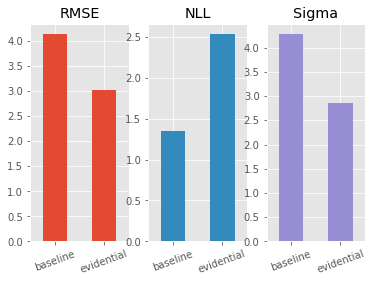

       baseline  evidential
RMSE   4.133465    3.029335
NLL    1.353120    2.526328
Sigma  4.271470    2.851516


In [87]:
from copy import deepcopy
from content.modules.utils import load_model
from content.evaluate import evaluate_model

models = {}
loaders_dict = {}
# getting each model
for idx, exp in enumerate(args.experiment_name):
    curr_args = deepcopy(args)
    curr_args.experiment_name, curr_args.model = exp, args.model[idx]
    # model
    models[exp] = load_model(curr_args)

# getting each dataset loader
for idx, data in enumerate(args.dataset):
    curr_args = deepcopy(args)
    curr_args.dataset =args.dataset[idx]
    # dataset
    loaders_dict[args.id_ood[idx]] = load_data(curr_args)

models['TOY1D-lambda0.001'].scalar = None
table_results = evaluate_model(loaders_dict=loaders_dict, models=models, experiments=args.experiment_name, args = args)

##### 3.3.1 - Out-of-Distribution performance

Similarly to above, we can evaluate out-of-distribution by specifying the correct input paramaters when running in evaluation mode. Running with the following arguments will compare the TOY1D evidential model on in- and out-of-domain data.

In [89]:
args = OmegaConf.create({})

# TRAINING-RELATED PARAMETERS
args.mode = 'evaluation'
args.data_dir = DATA_DIR
args.batch_size = BATCH_SIZE
args.dataset = ['TOY1D', 'TOY1D-OOD']
args.N_points = 1024
args.toy_noise_level = 3
args.id_ood = ['ID', 'OOD']

args.model = ['TOY1D', 'TOY1D']
args.experiment_name = ['TOY1D-lambda0.001', 'TOY1D-lambda0.001']
args.save_path = SAVE_PATH
args.device = 'cpu'
args.seed = SEED

### 4. Modeling graph-structured data - introducing Message-Passing Neural Networks <a class="anchor" id="4"></a>

We define two new models. Both are GNNs and follow almost the same structure. The real difference is again in the loss functions which will be the same as previously defined.

In [107]:
import torch
import os
class EvidentialGNN3D(torch.nn.Module):
    """Translation and rotation invariant graph neural network.

    Keyword Arguments
    -----------------
        output_dim : Dimension of output (default 2)
        state_dim : Dimension of the node states (default 10)
        num_message_passing_rounds : Number of message passing rounds
            (default 3)
    """

    def __init__(self, device, state_dim=10, num_message_passing_rounds=3, eps=1e-10):
        super().__init__()
        self.model_type = 'evidential'
        self.scalar = None

        # Set input dimensions and other hyperparameters
        self.state_dim = state_dim
        self.num_message_passing_rounds = num_message_passing_rounds

        # Define locked parameters
        self.edge_dim = 1
        self.output_dim = 4
        self.num_features = 4
        self.hidden_dim = 40

        # Message passing networks
        self.message_net = torch.nn.Sequential(
            torch.nn.BatchNorm1d(self.state_dim + self.num_features).double(),
            torch.nn.Linear(self.state_dim + self.num_features, self.hidden_dim).double(),
            torch.nn.Dropout(0.5),
            torch.nn.Tanh(),
            torch.nn.Linear(self.hidden_dim, 150).double(),
            torch.nn.Dropout(0.2),
            torch.nn.Tanh(),
            torch.nn.Linear(150, self.hidden_dim).double(),
            torch.nn.Dropout(0.8),
            torch.nn.Tanh(),
            torch.nn.Linear(self.hidden_dim, self.state_dim).double(),
            torch.nn.Dropout(0.5),
            torch.nn.Tanh(),
        )

        # Output net
        self.output_net = torch.nn.Sequential(
            torch.nn.Linear(self.state_dim, self.output_dim).double() # (gamma, v, alpha, beta)
        )

        # Initialize weights
        self.message_net.apply(self.init_weights)
        self.output_net.apply(self.init_weights)

        # Speficy activation functions
        self.softplus = torch.nn.Softplus()

        # Utilize GPU? #TODO: move this out of the class itself and into the run-script
        self.device = device
        self.eps = eps
        self.to(device)
          
    def init_weights(self, layer): # Found here: https://www.askpython.com/python-modules/initialize-model-weights-pytorch
        if type(layer) == torch.nn.Linear:
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu').double() # Kaiming for Relu
    

    def forward(self, x):
        """Evaluate neural network on a batch of graphs.

        Parameters
        ----------
        x: GraphDataset
            A data set object that contains the following member variables:

            node_coordinates : torch.tensor (N x 2)
                2d coordinates for each of the N nodes in all graphs
            node_graph_index : torch.tensor (N)
                Index of which graph each node belongs to
            edge_list : torch.tensor (E x 2)
                Edges (to-node, from-node) in all graphs
            node_to, node_from : Shorthand for column 0 and 1 in edge_list
            edge_lengths : torch.tensor (E)
                Edge features

        Returns
        -------
        out : N x output_dim
            Neural network output

        """
        # Initialize node features to zeros
        self.state = torch.zeros([x.num_nodes, self.state_dim]).to(self.device).double()

        # Loop over message passing rounds
        for _ in range(self.num_message_passing_rounds):
            # Preparing features
            e_len = x.edge_lengths
            coord_difference = torch.sum(torch.abs(x.node_coordinates[x.node_from] - x.node_coordinates[x.node_to]), axis=1)
            dot_coord = dot3D(x.node_coordinates[x.node_from], x.node_coordinates[x.node_to]).view(x.edge_lengths.shape)
            dot_diff = dot3D((x.node_coordinates[x.node_from] - x.node_coordinates[x.node_to]), x.edge_vectors).view(x.edge_lengths.shape)

            # Stacking features
            inp = torch.cat((self.state[x.node_from], 
                            e_len, 
                            coord_difference.view(e_len.shape),
                            dot_coord.view(e_len.shape),
                            dot_diff.view(e_len.shape),
                            ), 1)

            message = self.message_net(inp)

            if int(sum(sum(torch.isnan(message)))) > 0:
                stop = 1

            # Aggregate: Sum messages
            self.state.index_add_(0, x.node_to, message)
        # Aggretate: Sum node features
        self.graph_state = torch.zeros((x.num_graphs, self.state_dim)).to(self.device).double()
        self.graph_state.index_add_(0, x.node_graph_index, self.state)

        # Get parameters of NIG distribution (4-dimensional output)
        evidential_params_ = self.output_net(self.graph_state) # (gamma, v, alpha, beta)
        # Apply activations as specified after Equation 10 in the paper
        gamma, v, alpha, beta = torch.tensor_split(evidential_params_, 4, axis=1)
        out = torch.concat([gamma, self.softplus(v) + self.eps, self.softplus(alpha).add(1.0).to(torch.float64) + self.eps, self.softplus(beta) + self.eps], axis=1)
        return out

class BaselineGNN3D(torch.nn.Module):
    """Translation and rotation invariant graph neural network.

        Keyword Arguments
        -----------------
            output_dim : Dimension of output (default 2)
            state_dim : Dimension of the node states (default 10)
            num_message_passing_rounds : Number of message passing rounds
                (default 3)
        """

    def __init__(self, device, state_dim=20, num_message_passing_rounds=3):
        super().__init__()
        self.model_type = 'baseline'
        self.scalar = None

        # Set input dimensions and other hyperparameters
        self.state_dim = state_dim
        self.num_message_passing_rounds = num_message_passing_rounds

        # Define locked parameters
        self.edge_dim = 1
        self.output_dim = 2
        self.num_features = 4
        self.hidden_dim = 40

        # Message passing networks
        self.message_net = torch.nn.Sequential(
            torch.nn.BatchNorm1d(self.state_dim + self.num_features).double(),
            torch.nn.Linear(self.state_dim + self.num_features, self.hidden_dim).double(),
            torch.nn.Dropout(0.5),
            torch.nn.Tanh(),
            torch.nn.Linear(self.hidden_dim, 150).double(),
            torch.nn.Dropout(0.2),
            torch.nn.Tanh(),
            torch.nn.Linear(150, self.hidden_dim).double(),
            torch.nn.Dropout(0.8),
            torch.nn.Tanh(),
            torch.nn.Linear(self.hidden_dim, self.state_dim).double(),
            torch.nn.Dropout(0.5),
            torch.nn.Tanh(),
        )

        # Output net
        self.output_net = torch.nn.Sequential(
            torch.nn.Linear(self.state_dim, self.output_dim).double()  # (gamma, v, alpha, beta)
        )

        # Initialize weights
        self.message_net.apply(self.init_weights)
        self.output_net.apply(self.init_weights)

        # Speficy activation functions
        self.softplus = torch.nn.Softplus()

        # Utilize GPU? #TODO: move this out of the class itself and into the run-script
        self.device = device
        self.to(device)

    def init_weights(self,
                     layer):  # Found here: https://www.askpython.com/python-modules/initialize-model-weights-pytorch
        if type(layer) == torch.nn.Linear:
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_out',
                                          nonlinearity='relu').double()  # Kaiming for Relu

    def forward(self, x):
        """Evaluate neural network on a batch of graphs.

        Parameters
        ----------
        x: GraphDataset
            A data set object that contains the following member variables:

            node_coordinates : torch.tensor (N x 2)
                2d coordinates for each of the N nodes in all graphs
            node_graph_index : torch.tensor (N)
                Index of which graph each node belongs to
            edge_list : torch.tensor (E x 2)
                Edges (to-node, from-node) in all graphs
            node_to, node_from : Shorthand for column 0 and 1 in edge_list
            edge_lengths : torch.tensor (E)
                Edge features

        Returns
        -------
        out : N x output_dim
            Neural network output

        """
        # Initialize node features to zeros
        self.state = torch.zeros([x.num_nodes, self.state_dim]).double().to(self.device)

        # Loop over message passing rounds
        for _ in range(self.num_message_passing_rounds):
            e_len = x.edge_lengths
            coord_difference = torch.sum(torch.abs(x.node_coordinates[x.node_from] - x.node_coordinates[x.node_to]),
                                         axis=1)
            dot_coord = dot3D(x.node_coordinates[x.node_from], x.node_coordinates[x.node_to]).view(x.edge_lengths.shape)
            dot_diff = dot3D((x.node_coordinates[x.node_from] - x.node_coordinates[x.node_to]), x.edge_vectors).view(
                x.edge_lengths.shape)

            # Stacking features
            inp = torch.cat((self.state[x.node_from],
                             e_len,
                             coord_difference.view(e_len.shape),
                             dot_coord.view(e_len.shape),
                             dot_diff.view(e_len.shape),
                             ), 1)
            message = self.message_net(inp)

            # Aggregate: Sum messages
            self.state.index_add_(0, x.node_to, message)

        # Aggretate: Sum node features
        self.graph_state = torch.zeros((x.num_graphs, self.state_dim)).double().to(self.device)
        self.graph_state.index_add_(0, x.node_graph_index, self.state)

        # Get parameters of NIG distribution (4-dimensional output)
        evidential_params_ = self.output_net(self.graph_state)  # (gamma, v, alpha, beta)
        # Apply activations as specified after Equation 10 in the paper
        mu, sigma = torch.tensor_split(evidential_params_, 2, axis=1)
        out = torch.concat([mu, self.softplus(sigma)], axis=1)
        return out

def cross2D(v1, v2):
    """Compute the 2-d cross product.

    Parameters
    ----------
    v1, v2 : Array
        Arrays (shape Nx2) containing N 2-d vectors

    Returns
    -------
    Array
        Array (shape N) containing the cross products

    """
    return v1[:, 0] * v2[:, 1] - v1[:, 1] * v2[:, 0]

def dot3D(v1, v2):
    """Compute the 2-d dot product.

    Parameters
    ----------
    v1, v2 : Array
        Arrays (Nx2) containing N 3-d vectors

    Returns
    -------
    Array
        Array (shape N) containing the dot products

    """
    return v1[:, 0] * v2[:, 0] + v1[:, 1] * v2[:, 1] + v1[:, 2] * v2[:, 2]

#### 4.1 - Defining the synthetic setup <a class="anchor" id="4.1"></a>

In order to validate that our model works, we evaluate the model on synthetically generated data. We create the data by sampling atoms in a vector space. We use sklearn's "make_blobs" to sample these atoms. It works by defining finite a 3D coordinate system, for instance by defining a box between -3 and 3 on all three axes. In this box, we sample $n=3$ clusters at random. An atom is then sampled from a gaussian distribution with mean at a cluster point and standard deviation of 0.1. This way, we get $n$ atoms in our sampled molecule.

The distance between these atoms are now computed and given as edge weights in the fully connected graph that defines the molecule. The value used for prediction is retrieved by computing the force between molecules based on this force function:

$$
U(x) = \frac{a}{x^{12}} - \frac{b}{x^6}
$$

Where $a$ and $b$ are constants that we set to $a=500000$ and $b=4000$. The formula itself was found [here](https://www.toppr.com/ask/question/the-potential-energy-function-for-the-force-between-two-atoms/). The constants were set to these values in order to be able to create meaningful data; it is merely a scaling issue and might not reflect reality in any way. The important part about this formula is that it is non-linear:

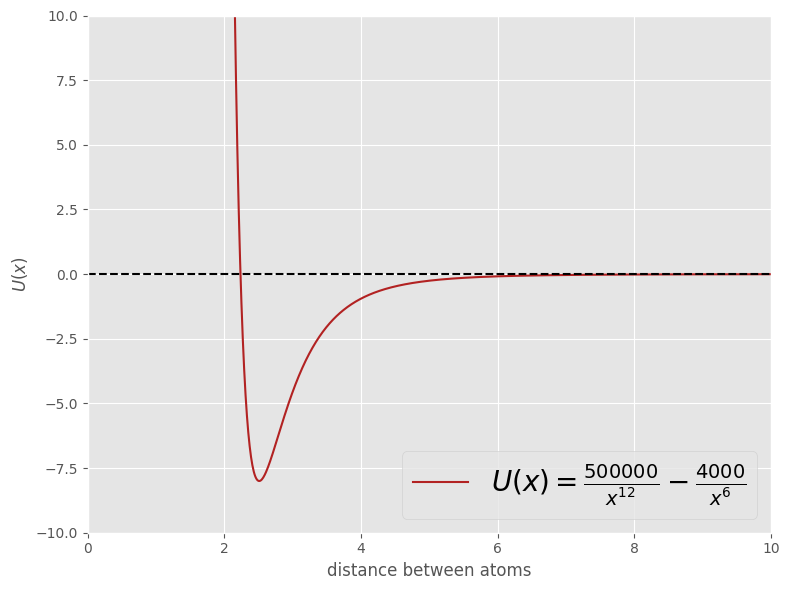

In [91]:
from content.plot_force_function import plot_gg
from content.synthetic_data_generation import U
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0.1,10,0.01)
y = np.array([U(xi) for xi in x])

plt.figure(figsize=(8,6),dpi=100)
plot_gg(x,y)

Two data sets were generated, one of which would be trained on by the EL model and the Gaussian-MLE model making it the ID data and the other one would only be run in evaluation mode making it the OOD data. To make sure that the loss behaves correctly, all molecules containing atoms that were closer than 2.30 were removed from both data sets.

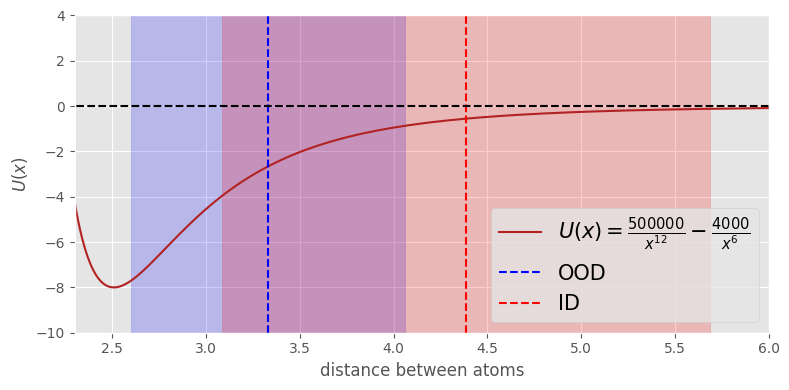

In [92]:
from content.plot_force_function import plot_gg_mstd
x = np.arange(0.1,10,0.01)
y = np.array([U(xi) for xi in x])
plt.figure(figsize=(8,4),dpi=100)
plt.vlines(2.30,-10,10)
plot_gg_mstd(x,y)

This figure shows the two data sets. There is an overlap, however, this is intentional as getting OOD data in real scenarios often corresponds to sampling data above a certain percentile and leaving it out of training.

#### 4.2 - Training the synthetic 3D model <a class="anchor" id="4.2"></a>

In order to train the models on the synthetic data set, we need to load the dataset to be trained on. The data we will be training on is the red span seen above; center box from -3 to 3.

In [108]:
from content.modules.utils import load_data
from omegaconf import OmegaConf

# Specify arguments for the load_data function
DATA_DIR = f'content/data'
DATASET = 'SYNTHETIC3'
BATCH_SIZE = 32
DEVICE ='cpu'
SEED = 42

# Create configuration dictionary
args = OmegaConf.create({'data_dir': DATA_DIR, 'dataset': DATASET,
                         'batch_size': BATCH_SIZE, 'device': DEVICE, 'seed': SEED})

# Create dataloaders
dataloaders = load_data(args)
print(f"Loaded toy dataset!\nDataset types available: {[type_ for type_ in dataloaders.keys() if dataloaders[type_] != None]}")


LOADED DATALOADER OBJECTS!
Loaded toy dataset!
Dataset types available: ['train', 'val', 'test']


Now we train both the Evidential GNN and our Gaussian MLE baseline on SYNTHETIC3 (center box = -3,3).

In [109]:
from run import determine_run_version

args = OmegaConf.create({})

# TRAINING-RELATED PARAMETERS
state_dim = 20
args.lr = LR = 5e-1
args.loss_function = LOSS_FUNCTION = 'NIGLoss'
args.epochs = EPOCHS = 625
args.seed = SEED = 0
args.device = DEVICE = 'cpu'

# EXPERIMENT-RELATED PARAMETERS
VAL_EVERY_STEP = 5
EXPERIMENT_NAME = 'Evidential_Synthetic'
args.tensorboard_logdir = TENSORBOARD_LOGDIR = 'logs'
args.save_path = SAVE_PATH = 'models'

# DATASET
args.batch_size = BATCH_SIZE
args.dataset = DATASET

In [110]:
from content.train import train
import numpy as np
best_epochs = {}
torch.manual_seed(0)
np.random.seed(0)
args.kappa = 0
args.kappa_decay = 1
args.NIG_lambda = NIG_LAMBDA = 0.7
EXPERIMENT_VERSION = f'lambda{NIG_LAMBDA}'
args.experiment_name = f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}"

# TRAINING-RELATED CLASSES
model = EvidentialGNN3D(device=args.device,state_dim=state_dim)
model.to(torch.device(args.device))

loss_function = NIGLoss(lambd_=NIG_LAMBDA)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Run training loop
os.makedirs(f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")
model, best_epoch = train(dataloaders, model, optimizer, loss_function, epochs=EPOCHS,
                          val_every_step=VAL_EVERY_STEP, experiment_name=f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}",
                          tensorboard_logdir=TENSORBOARD_LOGDIR, tensorboard_filename=determine_run_version(args),
                          save_path=f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")
best_epochs[NIG_LAMBDA] = best_epoch

Train Loss: 10.546 	 | 	 Train RMSE: 9.296 	 | 	 Val Loss: 20.428 	| 	 Val RMSE: 18.896 | Progress: 100%|██████████| 625/625 [01:54<00:00,  5.47it/s]   


EPOCH 285 --> BEST CHECKPOINT SAVED!	 Validation Loss: 9.907132772974041


Now the baseline

In [97]:
from run import determine_run_version

args = OmegaConf.create({})

# TRAINING-RELATED PARAMETERS
state_dim = 20
args.lr = LR = 5e-3
args.loss_function = LOSS_FUNCTION = "GAUSSIANNLL"
args.epochs = EPOCHS = 625
args.seed = SEED = 0
args.device = DEVICE = 'cpu'
args.model = 'BASE3D'

# EXPERIMENT-RELATED PARAMETERS
VAL_EVERY_STEP = 5
EXPERIMENT_NAME = 'Baseline_Synthetic'
args.tensorboard_logdir = TENSORBOARD_LOGDIR = 'logs'
args.save_path = SAVE_PATH = 'models'

# DATASET
args.batch_size = BATCH_SIZE
args.dataset = DATASET

In [98]:
from content.train import train
import numpy as np

best_epochs = {}
torch.manual_seed(1)
np.random.seed(1)
args.kappa = 0
args.kappa_decay = 1
args.experiment_name = EXPERIMENT_NAME

# TRAINING-RELATED CLASSES
model = BaselineGNN3D(device=args.device,state_dim=state_dim)
model.to(torch.device(args.device))

loss_function = GAUSSIANNLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Run training loop
os.makedirs(f"{SAVE_PATH}/{EXPERIMENT_NAME}")
model, best_epoch = train(dataloaders, model, optimizer, loss_function, epochs=EPOCHS,
                          val_every_step=VAL_EVERY_STEP, experiment_name=f"{EXPERIMENT_NAME}",
                          tensorboard_logdir=TENSORBOARD_LOGDIR, tensorboard_filename=determine_run_version(args),
                         save_path=f"{SAVE_PATH}/{EXPERIMENT_NAME}")

Train Loss: 3.953 	 | 	 Train RMSE: 11.255 	 | 	 Val Loss: 2.533 	| 	 Val RMSE: 7.462 | Progress: 100%|██████████| 625/625 [01:42<00:00,  6.07it/s]       


EPOCH 135 --> BEST CHECKPOINT SAVED!	 Validation Loss: 2.4413294804102983


#### 4.3 - Evaluating the synthetic 3D model <a class="anchor" id="4.3"></a>

Now we can evaluate the models on the ID and OOD data!

First, we evaluate our Evidential model:

In [113]:
from omegaconf import OmegaConf
from content.modules.utils import load_data

DATA_DIR = 'content/data'
BATCH_SIZE = 16
SAVE_PATH = 'models'
SEED = 0

args = OmegaConf.create({})

# TRAINING-RELATED PARAMETERS
args.mode = 'evaluation'
args.data_dir = DATA_DIR
args.batch_size = BATCH_SIZE
args.kappa = 0
args.kappa_decay = 1
args.dataset = ['SYNTHETIC3', 'SYNTHETIC2']
args.id_ood = ['ID', 'OOD']

args.model = ['GNN3D','GNN3D']
args.experiment_name = ['Evidential_Synthetic-lambda0.7','Evidential_Synthetic-lambda0.7']
args.save_path = SAVE_PATH
args.device = 'cpu'
args.seed = SEED


LOADED DATALOADER OBJECTS!

LOADED DATALOADER OBJECTS!
Save folder already exists


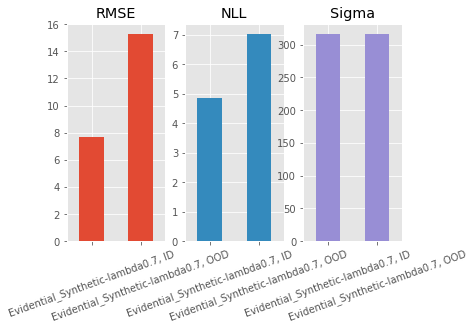

       Evidential_Synthetic-lambda0.7, ID  Evidential_Synthetic-lambda0.7, OOD
RMSE                             7.719541                            15.267394
NLL                              4.838243                             7.019850
Sigma                          316.227766                           316.227766


In [115]:
from copy import deepcopy
from content.modules.utils import load_model
from content.evaluate import evaluate_model

models = {}
loaders_dict = {}
# getting each model
for idx, exp in enumerate(args.experiment_name):
    curr_args = deepcopy(args)
    curr_args.experiment_name, curr_args.model = exp, args.model[idx]
    # model
    models[exp] = load_model(curr_args)
    models[exp].scalar = None
    #print(idx, exp)

# getting each dataset loader
for idx, data in enumerate(args.dataset):
    curr_args = deepcopy(args)
    curr_args.dataset =args.dataset[idx]
    # dataset
    loaders_dict[args.id_ood[idx]] = load_data(curr_args)

table_results = evaluate_model(loaders_dict=loaders_dict, models=models, experiments=args.experiment_name, args = args)

Then we can evaluate our Baseline in a likewise manner:

In [105]:
from omegaconf import OmegaConf
from content.modules.utils import load_data

DATA_DIR = 'content/data'
BATCH_SIZE = 16
SAVE_PATH = 'models'
SEED = 0

args = OmegaConf.create({})

# TRAINING-RELATED PARAMETERS
args.mode = 'evaluation'
args.data_dir = DATA_DIR
args.batch_size = BATCH_SIZE
args.dataset = ['SYNTHETIC3','SYNTHETIC2']
args.id_ood = ['ID','OOD']

args.model = ['BASE3D', 'BASE3D']
args.experiment_name = ['Baseline_Synthetic','Baseline_Synthetic']
args.save_path = SAVE_PATH
args.device = 'cpu'
args.seed = SEED


LOADED DATALOADER OBJECTS!

LOADED DATALOADER OBJECTS!
Save folder already exists


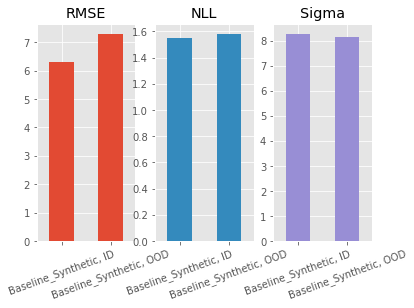

       Baseline_Synthetic, ID  Baseline_Synthetic, OOD
RMSE                 6.303416                 7.286900
NLL                  1.550606                 1.579654
Sigma                8.271384                 8.169859


In [106]:
from copy import deepcopy
from content.modules.utils import load_model
from content.evaluate import evaluate_model

models = {}
loaders_dict = {}
# getting each model
for idx, exp in enumerate(args.experiment_name):
    curr_args = deepcopy(args)
    curr_args.experiment_name, curr_args.model = exp, args.model[idx]
    # model
    models[exp] = load_model(curr_args)

# getting each dataset loader
for idx, data in enumerate(args.dataset):
    curr_args = deepcopy(args)
    curr_args.dataset =args.dataset[idx]
    # dataset
    loaders_dict[args.id_ood[idx]] = load_data(curr_args)

table_results = evaluate_model(loaders_dict=loaders_dict, models=models, experiments=args.experiment_name, args = args)

### 5. Applying uncertainty quantification to a down-stream task - Molecular Property prediction <a class="anchor" id="5"></a>


#### 5.1 - The QM7 dataset <a class="anchor" id="5.1"></a>



*Taken from:* https://www.kaggle.com/code/mjmurphy28/predicting-atomization-energy-qm7/notebook

*Original website:* http://quantum-machine.org/datasets/

**Attributes:**

- X: (7165 x 23 x 23), Coulomb matrices, low-level molecular descriptor (Rupp et al., 2012)
- T: (7165), atomization energies (unit: kcal/mol)
- P: (5 x 1433), cross-validation splits as used in [Montavon et al. NIPS, 2012]
- Z: (7165 x 23), atomic charges
- R: (7165 x 23 x 3), cartesian coordinate (unit: Bohr) of each atom in the molecules


I.e. it contains 23 atoms and 7165 molecules.

They say 'The Coulomb matrix has built-in invariance to translation and rotation of the molecule', because it is calculated by:

$$C_{ii} = \frac{1}{2} Z_i^{2.4} \text{ and } C_{ij} = \frac{Z_i Z_j}{|R_i - R_j|}$$

where $Z_i$ is the nuclear charge of atom $i$ and $R_i$ is its position. Thus translation and rotation of a molecule (the atoms positions) will not change the value of $C$.


In [116]:
import seaborn as sns
import scipy.stats as stats
from sklearn.manifold import TSNE
rand_state=0
plt.style.use('ggplot')


In [117]:
# the original data format
qm7 = scipy.io.loadmat('content/data/QM7/qm7.mat')

Distribution of target variable


/Users/felixburmester/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


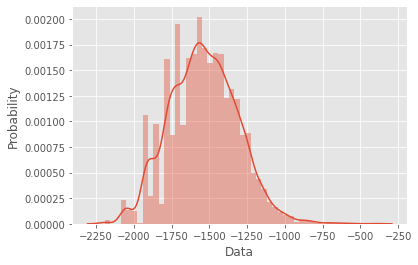

In [118]:
#plt.hist(data_dict['target'], density=True, bins=50)  # density=False would make counts
print('Distribution of target variable')

sns.distplot(qm7['T'][0]);
plt.ylabel('Probability')
plt.xlabel('Data');
plt.show()

QQ-plot of target variable compared to samples from a normal distribution


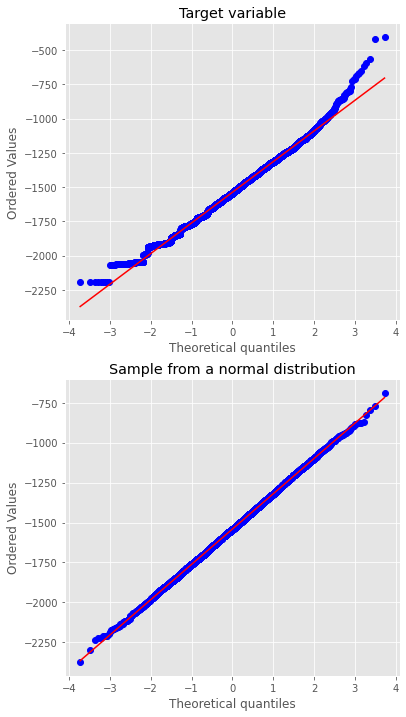

In [119]:
print('QQ-plot of target variable compared to samples from a normal distribution')

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6, 12))
#fig(figsize=(8, 6), dpi=80)
stats.probplot(qm7['T'][0], dist="norm", plot=ax1);
ax1.title.set_text('Target variable')
stats.probplot(np.random.normal(np.mean(qm7['T'][0]), np.std(qm7['T'][0]), len(qm7['T'][0])), dist="norm", plot=ax2);
ax2.title.set_text('Sample from a normal distribution')

plt.show()

**Note:**

Seems like target can be standardize (not normalized) since values lie somewhat on the theoretical quantiles

In [120]:
# flattening
cm = qm7['X'].reshape(len(qm7['X']), qm7['X'][0].shape[0]**2) # coulomb matrix atoms x atoms
z = qm7['Z']# atomic charge, one per atom
r = qm7['R'].reshape(len(qm7['R']), qm7['R'][0].shape[0]*qm7['R'][0].shape[1]) # cartesian coordinates, one per atom


t-SNE of coulomb matrix


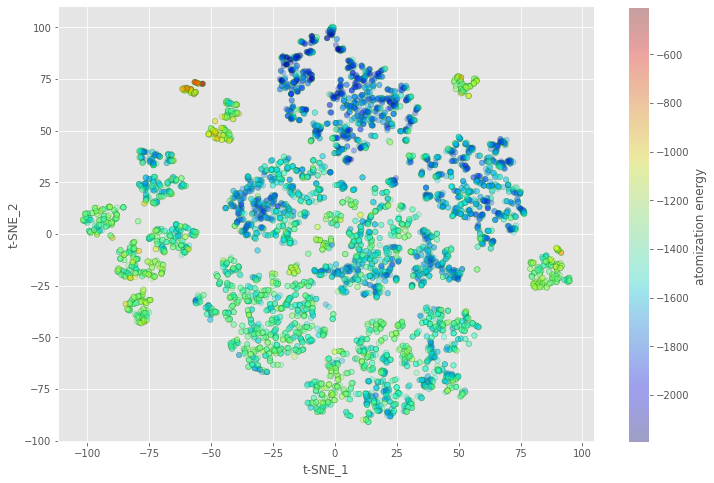

In [121]:
# another route, flatten

tsne = TSNE(n_components=2, random_state=rand_state, perplexity=30)
coulomb_tsne = tsne.fit_transform(cm)

print('t-SNE of coulomb matrix')

plt.figure(figsize=(12,8))
# based on T, atomization energy, the target
scatter = plt.scatter(coulomb_tsne[:,0], coulomb_tsne[:,1], c=qm7['T'], cmap=plt.colormaps['jet'], s=30, edgecolors='green', alpha=0.3)
plt.colorbar(scatter, label = "atomization energy ")
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
sns.despine()
plt.show()

t-SNE of all variables


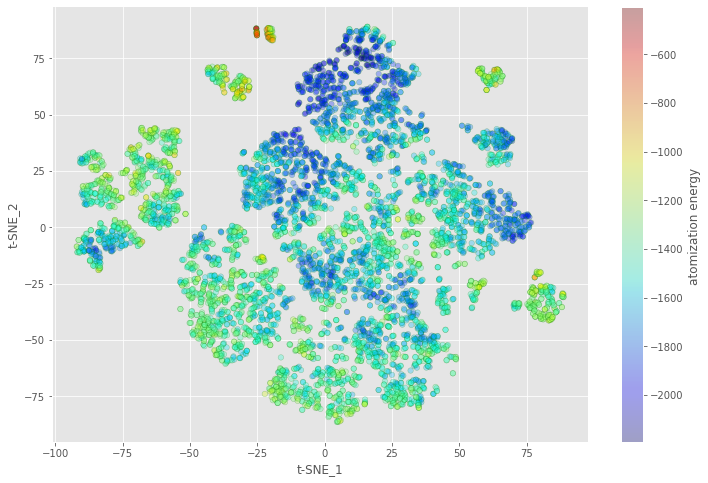

In [122]:
print('t-SNE of all variables')
X = np.concatenate((cm, z, r), axis=1)

tsne = TSNE(n_components=2, random_state=rand_state, perplexity=30)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,8))
# based on T, atomization energy, the target
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=qm7['T'], cmap=plt.colormaps['jet'], s=30, edgecolors='green', alpha=0.3)
plt.colorbar(scatter, label = "atomization energy ")
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
sns.despine()
plt.show()

#### 5.2 - Defining the model <a class="anchor" id="5.2"></a>

The class for the Evidential 3-dimensional graph model,  `EvidentialGNN3D`, used for the QM7 dataset is defined below: 

In [9]:
import torch
class EvidentialQM7_3D(torch.nn.Module):
    """Translation and rotation invariant graph neural network.

        Keyword Arguments
        -----------------
            output_dim : Dimension of output (default 2)
            state_dim : Dimension of the node states (default 10)
            num_message_passing_rounds : Number of message passing rounds
                (default 3)
        """

    def __init__(self, device, state_dim=32, num_message_passing_rounds=5, eps=1e-10):
        super().__init__()
        self.model_type = 'evidential'
        # Set input dimensions and other hyperparameters
        self.state_dim = state_dim
        self.num_message_passing_rounds = num_message_passing_rounds

        # Define locked parameters
        self.edge_dim = 1
        self.output_dim = 4
        self.num_features = 1
        self.h1_message = 128
        self.h2_message = 256
        self.h3_message = 256
        self.hidden_dim_output = 128

        # Message passing networks
        self.message_net = torch.nn.Sequential(
            torch.nn.Linear(self.state_dim + self.num_features, self.h1_message).double(),
            torch.nn.LayerNorm(self.h1_message).double(),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(self.h1_message, self.state_dim).double(),
            torch.nn.LayerNorm(self.state_dim).double(),
            torch.nn.LeakyReLU(),
        )

        # Output net
        self.output_net = torch.nn.Sequential(
            torch.nn.Linear(self.state_dim, self.hidden_dim_output).double(),
            torch.nn.Linear(self.hidden_dim_output, self.output_dim).double()
        )

        # Initialize weights
        self.message_net.apply(self.init_weights)
        self.output_net.apply(self.init_weights)

        # Speficy activation functions
        self.softplus = torch.nn.Softplus()

        # Utilize GPU? #TODO: move this out of the class itself and into the run-script
        self.eps = eps
        self.device = device
        self.to(device)

        self.scalar = None

    def init_weights(self,
                     layer):  # Found here: https://www.askpython.com/python-modules/initialize-model-weights-pytorch
        if type(layer) == torch.nn.Linear:
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_out',
                                          nonlinearity='leaky_relu').double()  # Kaiming for Relu

    def forward(self, x):
        """Evaluate neural network on a batch of graphs.

        Parameters
        ----------
        x: GraphDataset
            A data set object that contains the following member variables:

            node_coordinates : torch.tensor (N x 2)
                2d coordinates for each of the N nodes in all graphs
            node_graph_index : torch.tensor (N)
                Index of which graph each node belongs to
            edge_list : torch.tensor (E x 2)
                Edges (to-node, from-node) in all graphs
            node_to, node_from : Shorthand for column 0 and 1 in edge_list
            edge_lengths : torch.tensor (E)
                Edge features

        Returns
        -------
        out : N x output_dim
            Neural network output

        """
        # Initialize node features to zeros
        self.state = torch.zeros([x.num_nodes, self.state_dim]).double().to(self.device)

        # Loop over message passing rounds
        for _ in range(self.num_message_passing_rounds):
            e_len = x.edge_lengths
            e_coulomb = x.edge_coulomb
            
            # Stacking features
            inp = torch.cat((self.state[x.node_from],
                             e_coulomb, 
                             ), 1)
            message = self.message_net(inp)

            # Aggregate: Sum messages
            self.state.index_add_(0, x.node_to, message)

        # Aggretate: Sum node features
        self.graph_state = torch.zeros((x.num_graphs, self.state_dim)).double().to(self.device)
        self.graph_state.index_add_(0, x.node_graph_index, self.state)

        # Get parameters of NIG distribution (4-dimensional output)
        evidential_params_ = self.output_net(self.graph_state)  # (gamma, v, alpha, beta)
        # Apply activations as specified after Equation 10 in the paper
        gamma, v, alpha, beta = torch.tensor_split(evidential_params_, 4, axis=1)

        # if trained on scaled and in eval mode
        if self.scalar is not None and self.training==False:
            # de-scaling prediction
            gamma = torch.from_numpy(self.scalar.inverse_transform(gamma.detach()))

        out = torch.concat(
            [gamma, self.softplus(v) + self.eps, self.softplus(alpha).add(1.0).to(torch.float64) + self.eps,
             self.softplus(beta) + self.eps], axis=1)

        return out

#### 5.3 - Training the model - predicting molecular energy <a class="anchor" id="5.2"></a>

Below is the initialization of the model with all its parameters. The best model found for the QM7 dataset, was found to have a NIG loss of 0.75. 

The best model included a  $\kappa$-parameter, defining the ratio of which to weigh the RMSE as well as the intended NIGLoss like so: 

\begin{equation}
    \mathcal{L}^{\text{mod}}(\boldsymbol{w})= \kappa \cdot \mathcal{L}^{\text{RMSE}} + (1 - \kappa) \cdot \sum_i \mathcal{L}_i(\boldsymbol{w})
\end{equation}

Through optimization, the $\kappa$-parameter had initial value of 1.0, whereas it would decay by a multiplier f 0.99 at every epoch. 

A model trained solely on the NIGLoss, that is a $\kappa$-parameter of 0.0, has also been trained and included in the final paper. 

In [10]:
from content.modules.Losses import NIGLoss
from content.modules.utils import load_data


# Initializing arguments:
args = OmegaConf.create({'mode': 'train', 
                         'kappa': 1.0,
                         'kappa_decay': 0.99,
                         'scalar': 'none',
                         'loss_function': 'NIG',
                         'data_dir': 'content/data', 
                         'save_path': 'models',
                         'model': 'evidentialQM7',
                         'dataset': 'QM7',  
                         'batch_size': 64, 
                         'epochs': 200,
                         'lr': 5e-3,
                         'NIG_lambda': 0.75,
                         'val_every_step': 5,
                         'tensorboard_logdir': 'logs',
                         'experiment_name': 'EVIDENTIAL_QM7',
                         'id_ood': 'ID',
                         'device': 'cpu',
                         'seed': 0})

# setting seeds
torch.manual_seed(args.seed)
np.random.seed(args.seed)

# Create dataloaders
loaders = load_data(args)
loaders = {k: v for k, v in loaders.items() if k != 'visualization'}
#print(f"Loaded dataset!\nDataset types available: {[type_ for type_ in loaders.keys() if dataloaders[type_] != None]}")

# Load model
model = EvidentialQM7_3D(device=torch.device(args.device))
model.to(torch.device(args.device))
# Init loss
loss_function = NIGLoss(lambd_=args.NIG_lambda)
# Init Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
model.scalar=None


LOADED DATALOADER OBJECTS!


Below is a quick rundown of the Message-Passing-, as well as the output-network of the GNN:

In [11]:
print(model)

EvidentialQM7_3D(
  (message_net): Sequential(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (output_net): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
)


Finally, the model can be tained, through the following train loop:

In [12]:
from content.train import train
from content.modules.utils import save_model
from run import determine_run_version

try: # Creating folder
    os.makedirs(args.save_path + f"/{args.experiment_name}")
except Exception as e:
    print('Include --save_path, or folder already exists')

# Run training loop
model, best_epoch = train(loaders, model, optimizer,
                        loss_function=loss_function,
                        epochs=args.epochs,
                        kappa=args.kappa,
                        kappa_decay=args.kappa_decay,
                        val_every_step=args.val_every_step,
                        experiment_name=args.experiment_name,
                        tensorboard_logdir=args.tensorboard_logdir,
                        tensorboard_filename=determine_run_version(args),
                        save_path=f"{args.save_path}/{args.experiment_name}")

if args.save_path != '':
    save_model(model, args)

Include --save_path, or folder already exists


Train Loss: 24.475 	 | 	 Train RMSE: 26.052 	 | 	 Val Loss: 23.050 	| 	 Val RMSE


EPOCH 190 --> BEST CHECKPOINT SAVED!	 Validation Loss: 18.917543751091547


As is seen, the best model was found at Epoch 145, with a validation loss of 17.84.

Below is the final evaluation of the trainede model: 

#### 5.4 - Evaluating the model <a class="anchor" id="5.3"></a>


LOADED DATALOADER OBJECTS!


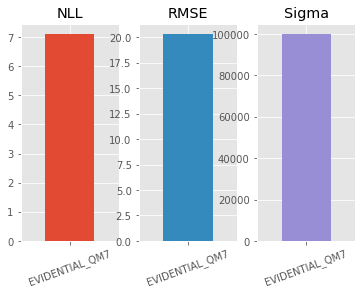

       EVIDENTIAL_QM7
NLL          7.105729
RMSE        20.311927
Sigma    99999.995863
None


In [27]:
from copy import deepcopy
from content.modules.utils import load_model, get_model_specifications, load_data, get_scalar
from content.evaluate import evaluate_model

# Initializing arguments:
args.dataset = [args.dataset]
args.model = [args.model]
args.scalar = [args.scalar]
args.experiment_name = [args.experiment_name]
args.id_ood = [args.id_ood]
args.NIG_lambda = [args.NIG_lambda]


models = {}
loaders_dict = {}
# getting each dataset loader
for idx, data in enumerate(args.dataset):
    curr_args = deepcopy(args)
    curr_args.dataset = args.dataset[idx]
    # dataset
    loaders_dict[args.id_ood[idx]] = load_data(curr_args)

# getting each model
for idx, exp in enumerate(args.experiment_name):
    curr_args = deepcopy(args)
    curr_args.experiment_name, curr_args.model = exp, args.model[idx]

    #if curr_args.loss_function == 'NIG':
    #    curr_args.experiment_name += f'-lambda{float(curr_args.NIG_lambda[0])}'

    # model
    model = load_model(curr_args)

    # if target is scaled, default none
    # todo: what if multiple ID datasetS
    scalar = get_scalar(loaders_dict['ID']['train'], args.scalar[idx])
    model.scalar = scalar
    #loss_function.scalar = scalar

    models[exp] = model

results_ = evaluate_model(loaders_dict=loaders_dict, models=models, experiments=args.experiment_name, args = args)
print(results_)



Now the same for the `BaselineGNN3D` model

In [42]:

class BaselineGNN3D(torch.nn.Module):
    """Translation and rotation invariant graph neural network.

        Keyword Arguments
        -----------------
            output_dim : Dimension of output (default 2)
            state_dim : Dimension of the node states (default 10)
            num_message_passing_rounds : Number of message passing rounds
                (default 3)
        """

    def __init__(self, device, state_dim=32, num_message_passing_rounds=5):
        super().__init__()
        self.model_type = 'baseline'
        # Set input dimensions and other hyperparameters
        self.state_dim = state_dim
        self.num_message_passing_rounds = num_message_passing_rounds

        # Define locked parameters
        self.edge_dim = 1
        self.output_dim = 2
        self.num_features = 1
        self.hidden_dim_message = 128
        self.hidden_dim_output = 128

        # Message passing networks
        self.message_net = torch.nn.Sequential(
            torch.nn.Linear(self.state_dim + self.num_features, self.hidden_dim_message).double(),
            torch.nn.LayerNorm(self.hidden_dim_message).double(),
            #torch.nn.BatchNorm1d(self.hidden_dim_message).double(),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(self.hidden_dim_message, self.state_dim).double(),
            torch.nn.LayerNorm(self.state_dim).double(),
            #torch.nn.BatchNorm1d(self.state_dim).double(),
            torch.nn.LeakyReLU(),
        )

        # Output net
        self.output_net = torch.nn.Sequential(
            torch.nn.Linear(self.state_dim, self.hidden_dim_output).double(),
            # --
            # standardize then include:
            torch.nn.LayerNorm(self.hidden_dim_output).double(),
            torch.nn.LeakyReLU(),
            # --
            torch.nn.Linear(self.hidden_dim_output, self.output_dim).double(),
        )

        # Initialize weights
        self.message_net.apply(self.init_weights)
        self.output_net.apply(self.init_weights)

        # Speficy activation functions
        self.softplus = torch.nn.Softplus()

        # Utilize GPU? #TODO: move this out of the class itself and into the run-script
        self.device = device
        self.to(device)
        self.scalar = None


    def init_weights(self,
                     layer):  # Found here: https://www.askpython.com/python-modules/initialize-model-weights-pytorch
        if type(layer) == torch.nn.Linear:
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_out',
                                          nonlinearity='leaky_relu').double()  # Kaiming for Relu


    def forward(self, x):
        """Evaluate neural network on a batch of graphs.

        Parameters
        ----------
        x: GraphDataset
            A data set object that contains the following member variables:

            node_coordinates : torch.tensor (N x 2)
                2d coordinates for each of the N nodes in all graphs
            node_graph_index : torch.tensor (N)
                Index of which graph each node belongs to
            edge_list : torch.tensor (E x 2)
                Edges (to-node, from-node) in all graphs
            node_to, node_from : Shorthand for column 0 and 1 in edge_list
            edge_lengths : torch.tensor (E)
                Edge features

        Returns
        -------
        out : N x output_dim
            Neural network output

        """


        # Initialize node features to zeros
        self.state = torch.zeros([x.num_nodes, self.state_dim]).double().to(self.device)

        # Loop over message passing rounds
        for _ in range(self.num_message_passing_rounds):
            e_len = x.edge_lengths
            e_coulomb = x.edge_coulomb

            # Stacking features
            inp = torch.cat((self.state[x.node_from],
                             e_coulomb,
                             ), 1)
            message = self.message_net(inp)

            # Aggregate: Sum messages
            self.state.index_add_(0, x.node_to, message)

        # Aggretate: Sum node features
        self.graph_state = torch.zeros((x.num_graphs, self.state_dim)).double().to(self.device)
        self.graph_state.index_add_(0, x.node_graph_index, self.state)

        # Get parameters of NIG distribution (4-dimensional output)
        evidential_params_ = self.output_net(self.graph_state)  # (gamma, v, alpha, beta)
        # Apply activations as specified after Equation 10 in the paper
        mu, var = torch.tensor_split(evidential_params_, 2, axis=1)
        var = self.softplus(var) # converting to positive
        # if trained on scaled and in eval mode
        if self.scalar is not None and self.training==False:
            # de-scaling prediction
            mu = torch.from_numpy(self.scalar.inverse_transform(mu.detach()))
            var = var.detach()*self.scalar.var_

        out = torch.concat([mu, var], axis=1)
        return out


In [50]:
from content.modules.Losses import GAUSSIANNLLLoss
from content.modules.utils import get_scalar

# Initializing arguments:
args = OmegaConf.create({'mode': 'train', 
                         'kappa': 1.0,
                         'kappa_decay': 0.99,
                         'data_dir': 'content/data', 
                         'save_path': 'models',
                         'dataset': 'QM7',  
                         'batch_size': 32, 
                         'epochs': 500,
                         'lr': 5e-5,
                         'val_every_step': 5,
                         'tensorboard_logdir': 'logs',
                         'experiment_name': 'BASELINE_QM7',
                         'scalar':'standardize',
                         'loss_function': 'GAUSSIANNLL',
                         'model': 'testbase',
                         'id_ood': 'ID',
                         'device': 'cpu',
                         'seed': 0})

# setting seeds
torch.manual_seed(args.seed)
np.random.seed(args.seed)

# Create dataloaders
loaders = load_data(args)
loaders = {k: v for k, v in loaders.items() if k != 'visualization'}
print(f"Loaded toy dataset!\nDataset types available: {[type_ for type_ in dataloaders.keys() if dataloaders[type_] != None]}")

# Load model
model = BaselineGNN3D(device=torch.device(args.device))
model.to(torch.device(args.device))
# Init loss
loss_function = GAUSSIANNLLLoss()
# Init Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)


# target is scaled
scalar = get_scalar(loaders['train'], args.scalar)
model.scalar = scalar
loss_function.scalar = scalar



LOADED DATALOADER OBJECTS!
Loaded toy dataset!
Dataset types available: ['train', 'val', 'test']


In [51]:
print(model)

BaselineGNN3D(
  (message_net): Sequential(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (output_net): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
)


In [52]:
from content.train import train
from content.modules.utils import save_model
from run import determine_run_version

try: # Creating folder
    os.makedirs(args.save_path + f"/{args.experiment_name}")
except Exception as e:
    print('Include --save_path, or folder already exists')

# Run training loop
model, best_epoch = train(loaders, model, optimizer,
                        loss_function=loss_function,
                        epochs=args.epochs,
                        kappa=args.kappa,
                        kappa_decay=args.kappa_decay,
                        val_every_step=args.val_every_step,
                        experiment_name=args.experiment_name,
                        tensorboard_logdir=args.tensorboard_logdir,
                        tensorboard_filename=determine_run_version(args),
                        save_path=f"{args.save_path}/{args.experiment_name}")

if args.save_path != '':
    save_model(model, args)

Include --save_path, or folder already exists


Train Loss: -1.641 	 | 	 Train RMSE: 22.639 	 | 	 Val Loss: -1.698 	| 	 Val RMSE


EPOCH 495 --> BEST CHECKPOINT SAVED!	 Validation Loss: -1.6977984571041935



LOADED DATALOADER OBJECTS!
Save folder already exists


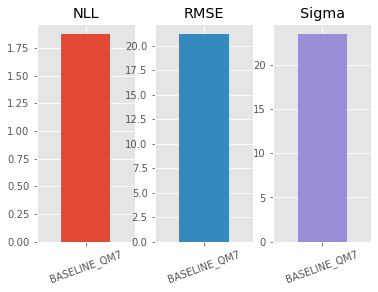

       BASELINE_QM7
NLL        1.873806
RMSE      21.129859
Sigma     23.483504
None


In [53]:
from copy import deepcopy
from content.modules.utils import load_model, get_model_specifications, load_data, get_scalar
from content.evaluate import evaluate_model

# Initializing arguments:
args.dataset = [args.dataset]
args.model = [args.model]
args.scalar = [args.scalar]
args.experiment_name = [args.experiment_name]
args.id_ood = [args.id_ood]



models = {}
loaders_dict = {}
# getting each dataset loader
for idx, data in enumerate(args.dataset):
    curr_args = deepcopy(args)
    curr_args.dataset = args.dataset[idx]
    # dataset
    loaders_dict[args.id_ood[idx]] = load_data(curr_args)

# getting each model
for idx, exp in enumerate(args.experiment_name):
    curr_args = deepcopy(args)
    curr_args.experiment_name, curr_args.model = exp, args.model[idx]

    if curr_args.loss_function == 'NIG':
        curr_args.experiment_name += f'-lambda{float(curr_args.NIG_lambda[0][0])}'

    # model
    model = load_model(curr_args)

    # if target is scaled, default none
    # todo: what if multiple ID datasetS
    scalar = get_scalar(loaders_dict['ID']['train'], args.scalar[idx])
    model.scalar = scalar
    #loss_function.scalar = scalar

    models[exp] = model

results_ = evaluate_model(loaders_dict=loaders_dict, models=models, experiments=args.experiment_name, args = args)
print(results_)



### 6. Discussion and Conclusion <a class="anchor" id="6"></a>

For the discussion and conclusion of the here-in trained models we refer to the paper.